### Imports

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import requests
import re

import seaborn as sns
import ast, powerlaw
from matplotlib.lines import Line2D

from urllib import request
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import time
import datetime
from tabulate import tabulate
import math
from PIL import Image

from nltk import FreqDist
from nltk import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
import pickle
import io
from matplotlib.pyplot import errorbar
import warnings
warnings.filterwarnings("ignore")

import random
from fa2 import ForceAtlas2
import os
from community import community_louvain
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sw = stopwords.words('english')
tk = nltk.WordPunctTokenizer()

# Motivation
All group members grew up with Pokémon, both playing the games and watching the anime. Since then, it has grown into becoming one of the largest game/anime franchises in the world, spanning an incredible 1115 episodes and hundreds of games. Additionally, Pokémon has a large community surrounding it, meaning that fan-made Wikipedia´s are abundant – with the largest one being Bulbapedia. 

Since our relationship with Pokémon is rooted in us being children, we didn’t get much insight into the series other than it being interesting/fun to watch. So, when an opportunity to do a deep dive into the universe to get a better understanding of the different characters and Pokémon, we were immediately interested. 

Therefore, we set out to create a website where the end-user can get information about the universe, explaining the statistics, characters, sentiments, and communities surrounding Pokémon.


# 1. Scraping the data

This section will focus on scraping the relevant data from the Bulbapedia website, to build a dataset fit for creating a network. To achieve this, the <code>requests</code> library is used to fetch the website, thereafter <code>BeautifulSoup4</code> is used to process the data into a format where you can directly access each element of the website. 

The process starts off by going to the website we want to scrape, and inspecting the elements, seeing what tags the data we want to scrape is inside. In this case, we wanted to scrape all character names, which were in tables that had the "width" element set to 75%. Thereafter we know that each table consists of a row with three columns, so looping through each row you can set append each cell to a list, that later on can be used to create the dataframe.

## 1.1 Scraping the base data

In [2]:
#Link to the main page that we want to scrape
url = "https://bulbapedia.bulbagarden.net/wiki/List_of_anime_characters"
#Sending a get request to the page to retrieve website information
characterPage = requests.get(url)

#Loading the data into a BeautifulSoup element to process it
soup = BeautifulSoup(characterPage.text, 'lxml')
#Locating the relevant tables
characterTable = soup.find_all('table',{'width':'75%'})

#Initalizing empty lists that we can append our values into
characterName = []
characterType = []
characterEpisode = []

#Looping over each table
for table in characterTable:
    #Finding all rows within this table
    tr = table.findAll("tr")
    for i, row in enumerate(tr):
        #Finding all data columns within this row
       td = row.findAll("td")
       #Looping over each data column and appending the correct data to the empty lists
       for i, data in enumerate(td):
            if i == 0:
                characterName.append(data.text)
            elif i == 1:
                characterEpisode.append(data.text)
            elif i == 2:
                characterType.append(data.text)

In [3]:
#Setting the dataframe to contain the newly created lists
df = pd.DataFrame({"Name":characterName, "Episode": characterEpisode, "Type":characterType})
#Noticing that the elements contain a newline tag at the end, removing this
df = df.replace('\n', '', regex=True)


Since we further down the road want to scrape the page content of each character to do NLP and sentiment analysis, storing the URL is a good idea for being able to easier do this.

In [4]:
url = "https://bulbapedia.bulbagarden.net/wiki/List_of_anime_characters"
characterPage = requests.get(url)
soup = BeautifulSoup(characterPage.text, 'lxml')
characterTable = soup.find_all('table',{'width':'75%'})

urlList = []
for table in characterTable:
    
    links = table.findAll("a")
    for i, link in enumerate(links):
        if link.text in list(df.Name):
            urlList.append(link.get("href"))

df['url'] = urlList

In [5]:
characterListFull = list(df['Name'])
characterURLFull = list(df['url'])

Inspecting the dataframe after first round of scraping is complete.

In [6]:
df.head(3)

,Name,Episode,Type,url
0,Ash Ketchum,EP001: Pokémon - I Choose You!,Main character,/wiki/Ash_Ketchum
1,Delia Ketchum,EP001: Pokémon - I Choose You!,"Relative, recurring character",/wiki/Delia_Ketchum
2,Gary Oak,EP001: Pokémon - I Choose You!,"Rival, recurring character",/wiki/Gary_Oak


In [7]:
#Removing all duplicates base don URL, as this is the only unique identifier
df.drop_duplicates(subset="url", inplace=True)

Checking how many unique characters we have

In [8]:
len(df)

1891

## 1.2 Scraping the edges

Now that the base data is scraped, we can start scraping the edges in the network - i.e. finding out what other character each character is connected to. This is a more complicated process, where each characters wikipage is visited, scraped for links, and doing a lookup where we check whether that link is part of our character in our dataframe. Since this involves going into 1891 wiki pages and scraping them for data, it takes quite some time (15 mintues on a M1 mac with 16GB ram), so we've commented it out and just loaded the dataset for you to use. If you have the time, however, feel free to comment it out!

In [9]:
#Initialzing and empty dataframe to contain the edges
df['Edges'] = np.zeros(len(df))

In [10]:
#Main loop for generating edges, quite simliar to the first one, just that we loop through each characters page and find the paragraphs in that page

## // COMMENT OUT IF YOU WANT TO RUN //


# requestSession = requests.session()
# characterListFull = list(df['Name'])
# characterURLFull = list(df['url'])

# def generateCharacterEdges(characterList, urlListen):

#     for i, character in enumerate(characterList):
#         characterPage = requestSession.get(f"https://bulbapedia.bulbagarden.net{characterURLFull[i]}")
#         soup = BeautifulSoup(characterPage.text, 'lxml')
#         characterDescription = soup.find('div',{'id':'bodyContent'})
#         characterEdges = []
#         charParag = characterDescription.findAll('p')

#         for parag in charParag:
#             links =  parag.findAll("a")
#             for link in links:
#                 name = link.get("title")
#                 if name in characterListFull and name != character and name not in characterEdges:
#                     characterEdges.append(name)

        
#         df['Edges'][i] = characterEdges
#         print(f"Completed {character}, {len(characterList)-i} remaining.")

        

# generateCharacterEdges(characterListFull, characterURLFull)

In [12]:
#Saving the file to reduce loading time of notebook
# df.to_excel("fullData.xlsx")
df = pd.read_excel("data/fullData.xlsx", index_col=0)
df.head(3)

,Name,Episode,Type,url,Edges
0,Ash Ketchum,EP001: Pokémon - I Choose You!,Main character,/wiki/Ash_Ketchum,"[""Ash's Pikachu"", 'Delia Ketchum', 'Gary Oak',..."
1,Delia Ketchum,EP001: Pokémon - I Choose You!,"Relative, recurring character",/wiki/Delia_Ketchum,"['Ash Ketchum', ""Ash's Pikachu"", 'Nurse Joy', ..."
2,Gary Oak,EP001: Pokémon - I Choose You!,"Rival, recurring character",/wiki/Gary_Oak,"['Ash Ketchum', 'Goh', ""Gary's cheerleaders"", ..."


## 2. Building the data and basic network statistics

In [13]:
#Index is a bit messy, so needs to be resetted
df.reset_index(inplace=True, drop=True)
df = df.rename(columns={"Type":"Character Type"})

### 2.1 Creating explanatory variables

Some imputation has to be done in order to make the dataset more fit for analysis, as the current state is not really manageable. In short, we are interested in in turning the previous dataset, as can be seen above, into a new one with these three added columns:
*   **Type:** In the original dataset, the character type column contained to much information. Each character has a value in this column, telling what type of character group they belong to, which is transformed into a new column with three values: main character (the most important characters for the overall show), recurring characters (those who appear multiple times throughout the series) and one-timers (those who only appear once).
*   **Relationship:** The relationship that the character has, in terms of the protagonist, Ash Ketchum. Multiple values exist in this column, so the value count have been printed below
*   **Collection:** It was found that the original debut episode column was not explanatory, so the values have been impeded to display the season collection they belong to, or if they are a "special" or movie.

Three functions are therafter created to establish the aforementioned columns:

In [14]:
#Initalizing three empty columns with the same lengths as the original dataset
df['Type'] = np.zeros(len(df))
df['Relationship'] = np.zeros(len(df))
df['Collection'] = np.zeros(len(df))

#Categorize the characters relationship with the protagonist
def findRelationship(string):
    if "aether" in string:
        return "Aether"
    elif "champion" in string:
        return "Champion"
    elif "elite four" in string:
        return "Elite Four"
    elif "gym leader" in string:
        return "gym leader"
    elif "relative" in string:
        return "Relative"
    elif "rival" in string:
        return "Rival"
    elif "team rocket" in string:
        return "Team Rocket"
    elif "team aqua" in string:
        return "Team Aqua"
    elif "team flare" in string:
        return "Team Flare"
    elif "galactic" in string:
        return "Galactic"
    elif "team magma" in string:
        return "Team Magma"
    elif "team plasma" in string:
        return "Team Plasma"
    elif "team skull" in string:
        return "Team Skull"
    else:
        return "Other"

#Find the collection the character belongs to
def findSeries(string):
    if "EP" in string:
        return "Original series"
    elif "AG" in string:
        return "Advanced generation"
    elif "DP" in string:
        return "Diamond and pearl"
    elif "BW" in string:
        return "Black & White"
    elif "XY" in string:
        return "XY"
    elif "SM" in string:
        return "Sun & Moon"
    elif "JN" in string:
        return "Journeys"
    elif "M" in string:
        return "Movie"
    elif "HS" in string:
        return "Side story"
    else:
        return "Specials"

#Find out the character type, and fill out the missing columns with the previous functions
def fillMissingData():
    for i, row in enumerate(df["Character Type"].str.split(", ")):
        try:
            row = (str(row).lower())
            if "main" in row:
                df['Type'][i] = "Main"
            elif "recurring" in row:
                df['Type'][i] = "Recurring"
            else:
                df['Type'][i] = "One-timer"

            if "pokémon" in row:
                df['Relationship'][i] = "Pokémon"
            else:
                df['Relationship'][i] = findRelationship(row)
        except Exception as e:
            print(e)
    
    for i, row in enumerate(df['Episode'].str.split(":")):
        episode = (str(row[0]).upper())
        df['Collection'][i] = findSeries(episode) 

#Running the function
fillMissingData()
df.head(3)

,Name,Episode,Character Type,url,Edges,Type,Relationship,Collection
0,Ash Ketchum,EP001: Pokémon - I Choose You!,Main character,/wiki/Ash_Ketchum,"[""Ash's Pikachu"", 'Delia Ketchum', 'Gary Oak',...",Main,Other,Original series
1,Delia Ketchum,EP001: Pokémon - I Choose You!,"Relative, recurring character",/wiki/Delia_Ketchum,"['Ash Ketchum', ""Ash's Pikachu"", 'Nurse Joy', ...",Recurring,Relative,Original series
2,Gary Oak,EP001: Pokémon - I Choose You!,"Rival, recurring character",/wiki/Gary_Oak,"['Ash Ketchum', 'Goh', ""Gary's cheerleaders"", ...",Recurring,Rival,Original series


Dropping the columns we used to transform the values

In [15]:
df.drop(['Episode', 'Character Type', 'url'], axis=1, inplace=True)

Movies and specials isn't part of the original anime series, and are therefore dropped

In [16]:
df = df[(df.Collection != "Movie") & (df.Collection != "Specials")]

### 2.2 Preparing the data for building the network

There are some cells in the edges column that have the value of 0, these need to be replaced with np.nan to be used correctly

In [17]:
df['Edges'] = df['Edges'].replace(0, np.nan)

The edges column consists of a list of strings. Loading this in as a .CSV file, however, doesn't format the column correctly. The <code>ast.literal_eval()</code> module can then be used to correctly format the column into a list format (which it needs to be for it ot be converted into a NetworkX graph)


In [18]:
df.Edges = df.Edges.map(lambda a: ast.literal_eval(a) if pd.notnull(a) else a)

With the column correctly classified, you can access each element of a cell, just as you would with a normal python list as seen below.

In [19]:
#Checking the edges for the 2nd element in our dataset, Delia Ketchum, the protagonists' mother
df.Edges[1][0:3]

['Ash Ketchum', "Ash's Pikachu", 'Nurse Joy']

Now that the columns have been transformed into the correct datatype, the <code>.explode()</code> function in Pandas can be used to explode the edgelist into multiple column, which is needed for networkX.

In [20]:
df = df.explode('Edges')
#Removing all nans
df = df.dropna(axis=0)
print(f"Dataset is now {len(df)} rows.")

Dataset is now 11007 rows.


### 2.3 Building the network

Now that the data is prepared, the actual network can be built. To do this, the <code>nx.from_pandas_edgelist</code> is used with the nodes set to being the "name" column and edges set to the "Edges" column. A directional graph has been selected as the format since this allows for investigation of both in- and out degrees. Thereafter, the Giant Connected Component is extracted to not include isolated nodes/smaller clusters.

In [21]:
#Creating the whole network
G = nx.from_pandas_edgelist(df, "Name", "Edges", edge_attr=True, create_using=nx.DiGraph())
#Extracting the Giant Connected Component (GCC)
GCC = G.subgraph(sorted(nx.weakly_connected_components(G), key=len, reverse=True)[0])

### 2.4 Basic network statistics

In [22]:
print(f"Number of nodes in the network: {len(GCC.nodes())}")
print(f"Number of edges in the network: {len(GCC.edges())}")
print(f"Average degree: {round(len(GCC.edges())/len(GCC.nodes()), 2)}")

Number of nodes in the network: 1588
Number of edges in the network: 10955
Average degree: 6.9


In [23]:
topConnectedIn = sorted(GCC.in_degree, key=lambda x: x[1], reverse=True)[0]
print(f"The top connected character based on in-degrees is: {topConnectedIn[0]}, who has {topConnectedIn[1]} inwards connections.")
topConnectedOut = sorted(GCC.out_degree, key=lambda x: x[1], reverse=True)[0]
print(f"The top connected character based on out-degrees is: {topConnectedOut[0]}, who has {topConnectedOut[1]} outwards connections.")

The top connected character based on in-degrees is: Ash Ketchum, who has 1227 inwards connections.
The top connected character based on out-degrees is: Ash's Pikachu, who has 199 outwards connections.


Who are the top five characters in terms of type? I.e. main, recurring and one-time characters

In [24]:
#Creating a function that takes in a dataframe that is modified to only contain the relevant role, and the GCC
def findTop(inputDF, inputNetwork):

    inDegree = list(sorted(inputNetwork.in_degree, key=lambda x: x[1], reverse=True))
    outDegree = list(sorted(inputNetwork.out_degree, key=lambda x: x[1], reverse=True))

    #Sub function for calculating the top five characters within the given role
    def topFive(inputList):
        counter = 0
        placeHolderList = []
        for value in inputList:
            if value[0] in list(inputDF['Name']):
                placeHolderList.append(value)
                counter += 1
            if counter == 5:
                return placeHolderList
            
    inDegreeList = topFive(inDegree)
    outDegreeList = topFive(outDegree)

    #Returning both in- and out degree for the relevant characters
    return inDegreeList, outDegreeList

#Function for printing out the relevant information
def printTop(inputList, types, inOut, amount=5):

    print(f"\n-----Top {amount} {types} with {inOut} degree------")
    
    for i, character in enumerate(inputList):
        print(f"#{i}: {character}")


#### Top five main characters' in-out degree

In [25]:
onlyMain = df.loc[df['Type'] == "Main"]

topIn, topOut = findTop(onlyMain, GCC)


printTop(topIn, "Main Characters", "inwards")
printTop(topOut, "Main Characters", "outwards")


-----Top 5 Main Characters with inwards degree------
#0: ('Ash Ketchum', 1227)
#1: ("Ash's Pikachu", 608)
#2: ('Jessie', 235)
#3: ('James', 171)
#4: ('Goh', 149)

-----Top 5 Main Characters with outwards degree------
#0: ("Ash's Pikachu", 199)
#1: ('Ash Ketchum', 86)
#2: ('Jessie', 79)
#3: ('James', 65)
#4: ('Meowth', 63)


#### Top five recurring characters' in-out degree

In [26]:
onlyMain = df.loc[df['Type'] == "Recurring"]

topIn, topOut = findTop(onlyMain, GCC)


printTop(topIn, "Recurring Characters", "inwards")
printTop(topOut, "Recurring Characters", "outwards")


-----Top 5 Recurring Characters with inwards degree------
#0: ('Officer Jenny', 115)
#1: ('Nurse Joy', 115)
#2: ('Butch', 53)
#3: ('Cassidy', 52)
#4: ('Giant Rock', 47)

-----Top 5 Recurring Characters with outwards degree------
#0: ('Nurse Joy', 48)
#1: ('Officer Jenny', 43)
#2: ('Seel', 43)
#3: ('Anthony', 39)
#4: ('Schwarz', 39)


Top five one-time characters' in-out degree

In [27]:
onlyMain = df.loc[df['Type'] == "One-timer"]

topIn, topOut = findTop(onlyMain, GCC)


printTop(topIn, "One-time Characters", "inwards")
printTop(topOut, "One-time Characters", "outwards")


-----Top 5 One-time Characters with inwards degree------
#0: ('Max', 84)
#1: ('Lt. Surge', 30)
#2: ('Koga', 30)
#3: ('Norman', 27)
#4: ('Leon', 21)

-----Top 5 One-time Characters with outwards degree------
#0: ('Damian', 39)
#1: ('Anthony', 39)
#2: ('Fiorella Cappuccino', 37)
#3: ('Daniel', 35)
#4: ('Timmy', 34)


Interesting... Seems like there is a smaller gap than anticipated between the recurring characters, and one-time characters. Let´s explore this further by plotting the average degree for each type

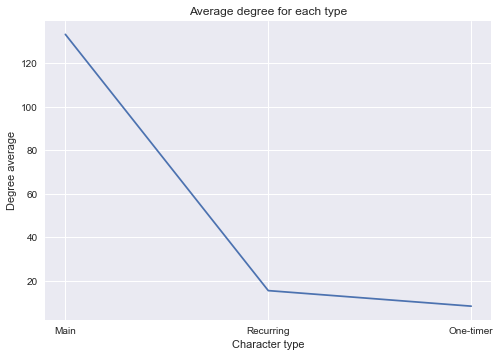

In [28]:
#Transforming each character degree into a dataframe
degrees = pd.DataFrame.from_dict(dict(GCC.degree), orient="index", columns=["Degree count"])
#Mergin it with the original dataframe
degreeDF = pd.merge(df, degrees, how="right", left_on="Name", right_on=degrees.index)
#Dropping duplicates since we previously exploded it (imploding)
degreeDF.drop_duplicates(subset="Name", inplace=True)
plt.style.use("seaborn")
plt.title("Average degree for each type")
plt.ylabel("Degree average")
plt.xlabel("Character type")
#Grouping by type and calculating the mean, and plotting it in descending order
plt.plot(degreeDF.groupby(['Type']).mean()['Degree count'].sort_values(ascending=False))
plt.show()

As could be seen from the previous analysis, there is a rather large discrepancy between the main characters and recurring for the different characters when taking their type (i.e. frequency in the series) into consideration. In order to get more insight into this, a degree distrubtion plot will be plotted for both in- and out degrees, which should provide a powerlaw distribution given the previous results.

Text(0.5, 0, 'Amount of outward links')

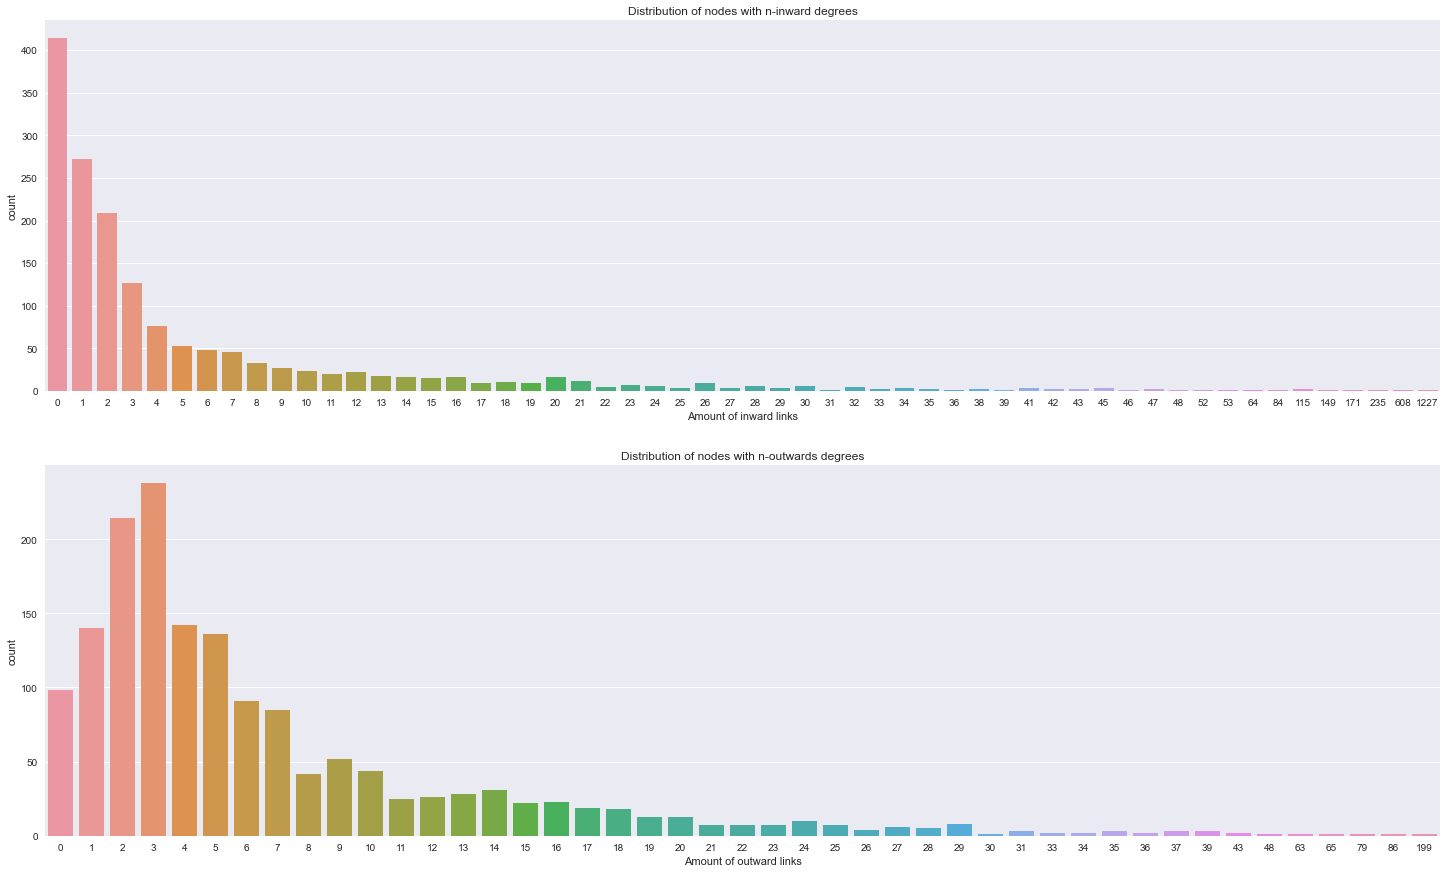

In [29]:
#Dividing into two subplots stacked, to more easily see the differences
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(25,15)

#Using the seaborn library to plot the counts of each degree distrubtion
sns.countplot(list(dict(GCC.in_degree).values()), ax=axs[0])
axs[0].set_title("Distribution of nodes with n-inward degrees")
axs[0].set_xlabel("Amount of inward links")


sns.countplot(list(dict(GCC.out_degree).values()), ax=axs[1])
axs[1].set_title("Distribution of nodes with n-outwards degrees")
axs[1].set_xlabel("Amount of outward links")



In [30]:
def powerlaw_exponent(degreeList):
    gamma = powerlaw.Fit(degreeList).alpha
    return gamma
    
inDegree = powerlaw_exponent(list((dict(GCC.in_degree).values())))
outDegree = powerlaw_exponent(list((dict(GCC.out_degree).values())))

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [31]:
print(f"""
Exponent for the in-degree: {inDegree} 
Exponent for the out-degree: {outDegree} 
""")


Exponent for the in-degree: 3.0575032862708302 
Exponent for the out-degree: 4.382858338850941 



The results indicate that both the in-degree and out-degree distribution falls into the Random Network Regime, although just barely in the in-degree distribution ((2 >  γ < 3) is a scale-free regime) (Barbasi, 4.7). This will explain the more frequent hubs in the in-degree opposed to the out-degree.

### 2.5 Building the network

Now its time to build the actual network. First, the network must be converted from directed to undirected

In [32]:
GCC = GCC.to_undirected()

Thereafter different functions are created for styling the graph in order to make it more descriptive and visually appealing.<br> The first styling option is to color the nodes according to the collection they belong to.

In [33]:
#Creating a key/value pair for the collection and the color they should be
typeColors ={
    "Original series":"#ff4040",
    "Sun & Moon":"#ffff00",
    "XY":"#20b2aa",
    "Black & White":"#333333",
    "Diamond and pearl":"#c6e2ff",
    "Advanced generation":"#ff43a4",
    "Journeys":"#191970",
    }

In [34]:
#Defining a function that takes in a graph and a dataframe for lookup to check what collection the character belongs to
def getNodeColors(graph, dataframe):

    colorMap = []
    for collection in graph:
        try:
            collectionBelong = list(dataframe[dataframe.Name==collection]['Collection'])[0]
            colorMap.append(typeColors[collectionBelong])
        except:
            colorMap.append("#c5b9cd")
    return colorMap

Next, it would be informative to size the nodes according to their degree count

In [35]:
def getNodeSize(graph, multiplier):
    degrees = dict(graph.degree)
    return [v*multiplier for v in degrees.values()]

Thereafter, the edges are being colored according to the relationship between them. If both nodes belong to the same collection, the edges are colored green. If not, red.

In [36]:
def edgeColor(G, dataframe):
    colorMap = []
    fullDF = dataframe
    fullDF.drop_duplicates(subset=['Name'], inplace=True)
    edgeDict = G.edges()
    for edge in edgeDict.keys():
        role1 = str(fullDF.loc[fullDF['Name'] == edge[0]]['Collection'].values)
        role2 = str(fullDF.loc[fullDF['Name'] == edge[1]]['Collection'].values)
        def removeUnwantedChars(_string):
            _string = _string.replace("[","")
            _string = _string.replace("'","")
            _string = _string.replace("]","")
            return _string

        role1 = removeUnwantedChars(role1)
        role2 = removeUnwantedChars(role2)

        if role1 == role2:
            colorMap.append("green")
        else:
            colorMap.append("red")

    return colorMap

The last key component in styling the graph, is plotting the labels of the most connected characters to more easily identify hubs and what character is the center of different hubs.

In [37]:
def generateLabels(graph, labelAmount):
    topTenConnected = list(dict(sorted(graph.degree, key=lambda x: x[1], reverse=True)[:int(labelAmount)]).keys())
    labels = {}

    for node in graph.nodes():
        if node in topTenConnected:
            labels[node] = node
    return labels

Now that all styling functions have been created, <code>ForceAtlas2</code> can be used to find the position of the nodes, and the styling functions can be called to style different elements.

In [38]:
def plotNetwork(graph, dataframe, labelAmount, sizeMultiplier, edgeWidth, edgeAlpha, notebookPlot):
        from fa2 import ForceAtlas2
        forceatlas2 = ForceAtlas2(
        # Behavior alternatives
        outboundAttractionDistribution=False,  # Dissuade hubs
        edgeWeightInfluence = 0.5, # Performance

        # Performance
        jitterTolerance=.2,  # Tolerance
        barnesHutOptimize=True,
        barnesHutTheta=.7,

        # Tuning
        scalingRatio=3.0,
        strongGravityMode=False,
        gravity=.5,

        # Log
        verbose=False
        )

        # Initialize
        plt.figure(figsize=(14,14))

        # Calculate positions
        positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=1000)

        nx.draw_networkx_nodes(
        graph,
        positions,
        node_size=getNodeSize(graph, sizeMultiplier),
        node_color=getNodeColors(graph, dataframe))
        nx.draw_networkx_edges(
        graph,
        positions,
        width=edgeWidth,
        edge_color=edgeColor(graph, dataframe),
        alpha=edgeAlpha
        )

        #Since the notebook is white background and the webpage is darkmode, the labels need to be adjusted
        if notebookPlot == "yes":
                labelColor = "#000000"
        else:
                labelColor = "FFFFFF"

        labels = generateLabels(graph, labelAmount)
        nx.draw_networkx_labels(graph, positions, labels, font_size=10, font_color=labelColor, font_weight="bold")
        plt.axis('off')

        # Legend
        legend_elements =[Line2D([0], [0], marker='o', color='#F5F5F5', label='Original series',
                                markerfacecolor='#ff4040', markersize=15, alpha=0.4),
                        Line2D([0], [0], marker='o', color='#F5F5F5', label='Sun & Moon',
                                markerfacecolor='#ffff00', markersize=15, alpha=0.4),
                        Line2D([0], [0], marker='o', color='#F5F5F5', label='XY',
                                markerfacecolor='#20b2aa', markersize=15, alpha=0.4),
                        Line2D([0], [0], marker='o', color='#F5F5F5', label='Black & White',
                                markerfacecolor='#333333', markersize=15, alpha=0.4),
                        Line2D([0], [0], marker='o', color='#F5F5F5', label='Diamond and pearl',
                                markerfacecolor='#c6e2ff', markersize=15, alpha=0.4),
                        Line2D([0], [0], marker='o', color='#F5F5F5', label='Advanced generation',
                                markerfacecolor='#ff43a4', markersize=15, alpha=0.4),
                        Line2D([0], [0], marker='o', color='#F5F5F5', label='Journeys',
                                markerfacecolor='#191970', markersize=15, alpha=0.4)
                                ]

        plt.legend(handles = legend_elements, facecolor = "#F5F5F5", loc=1, fontsize = 14)
        # plt.savefig("network.png", format='png', transparent=True)

        plt.show()

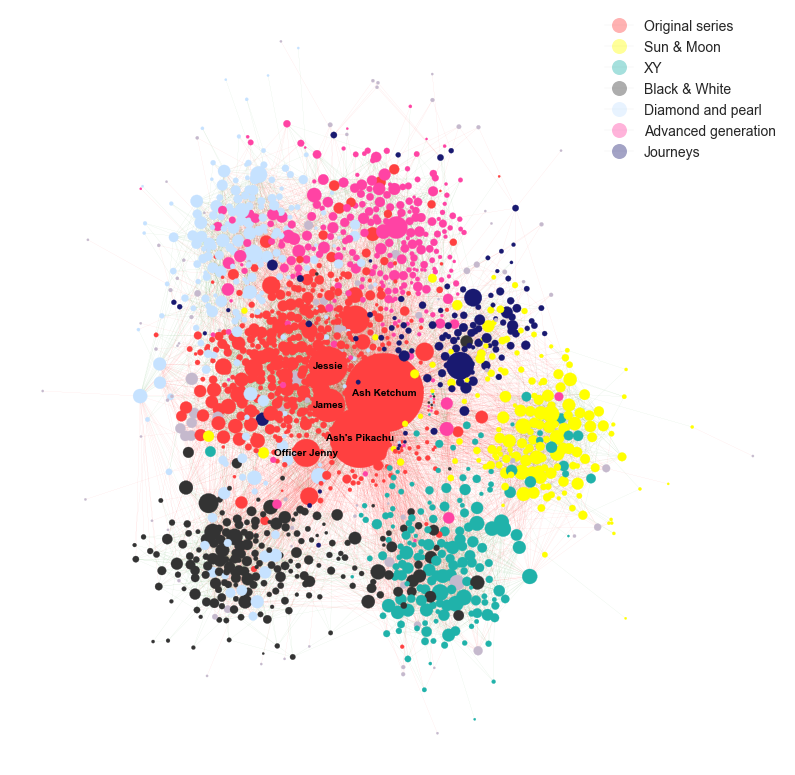

In [39]:
#Plotting the giant connected component of the whole network, with labels on the five largest nodes
plotNetwork(GCC, df, 5, 5, .1, .3, "yes")

Not surprisingly, the network is very dense. As noticed in the degree distribution, there are a few characters that have hubs that dominate the network – whereas the others seem to be surrounding these. There also doesn’t seem to be much difference between the seasons, where most seasons seem to be grouped together and have the common denominator of being connected to the main characters.

Finally, let’s have a look at some smaller parts of our network.

#### 2.5.1 Creating smaller networks

Starting off, we remove the main characters, as they would dominate every network. So let's see if there are some minor characters that play a larger role in the network, by trimming the dataframe to a certain subset and extracting the Giant Connected Component from this network.

In [40]:
mainCharacters = list(df[df.Type=="Main"]["Name"].unique())

Creating a network for only the Pokémon

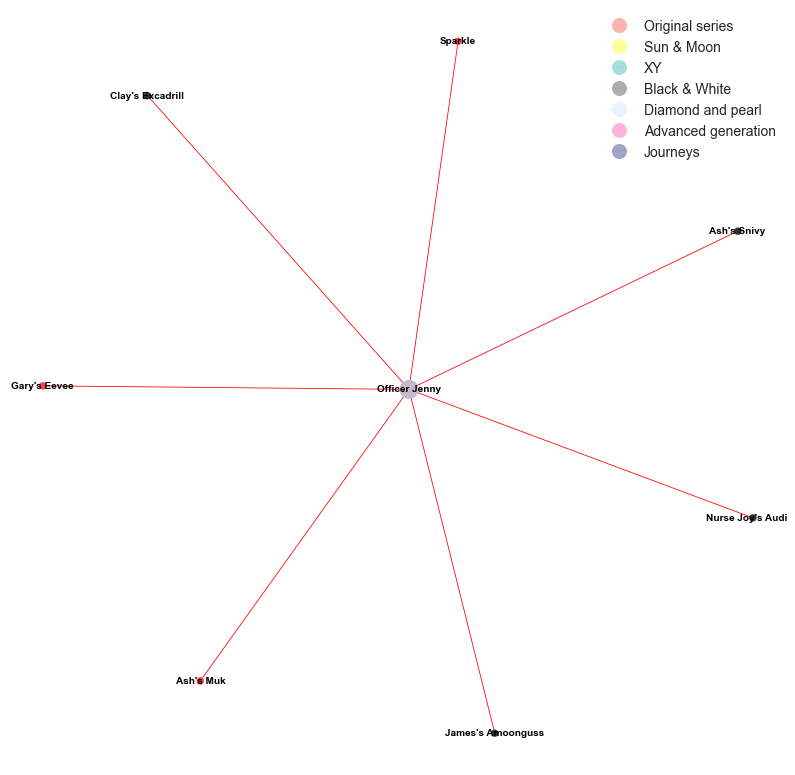

In [41]:
oneTimers = df[df.Relationship == "Pokémon"]
oneTimers = oneTimers[~df.Edges.isin(mainCharacters)]
V = nx.from_pandas_edgelist(oneTimers, "Name", "Edges", edge_attr=True, create_using=nx.DiGraph())
VCC = V.subgraph(sorted(nx.weakly_connected_components(V), key=len, reverse=True)[0])
VCC = VCC.to_undirected()
plotNetwork(VCC, oneTimers, 10, 50, .8, 1, "yes")

Creating a network with the recurring characters

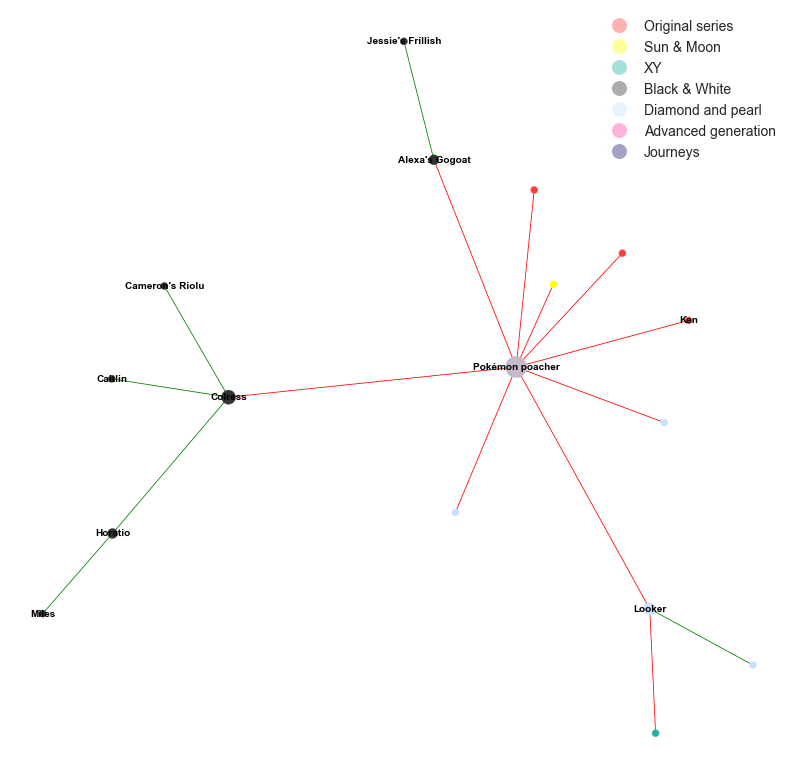

In [42]:
recurring = df[df.Type == "Recurring"]
recurring = recurring[~df.Edges.isin(mainCharacters)]
V = nx.from_pandas_edgelist(recurring, "Name", "Edges", edge_attr=True, create_using=nx.DiGraph())
VCC = V.subgraph(sorted(nx.weakly_connected_components(V), key=len, reverse=True)[0])
VCC = VCC.to_undirected()
plotNetwork(VCC, recurring, 10, 50, .8, 1, "yes")

Creating a network with the characters that appear in only one episode

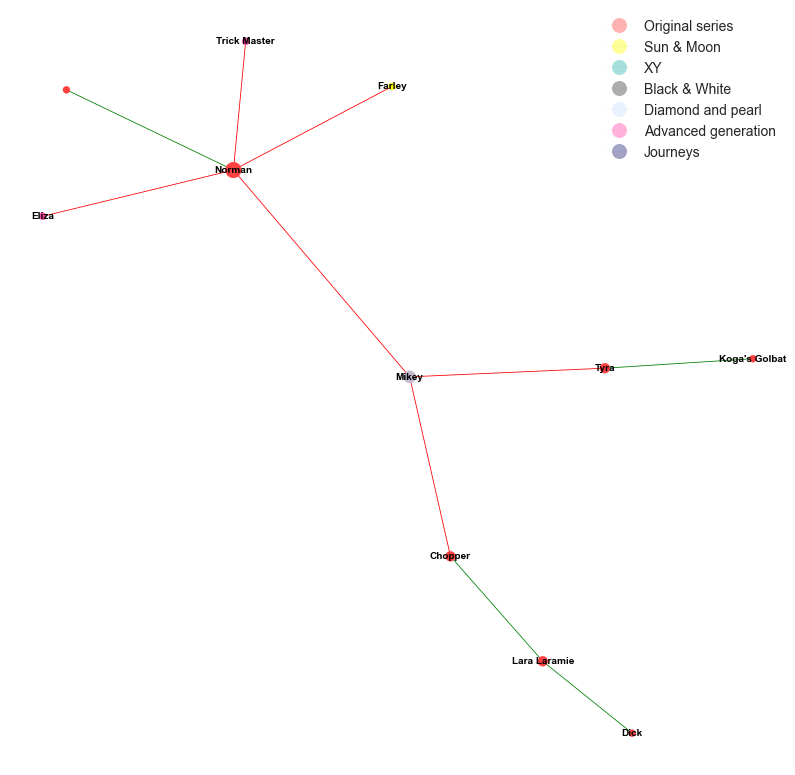

In [43]:
oneTimer = df[df.Type == "One-timer"]
oneTimer = oneTimer[~df.Edges.isin(mainCharacters)]
V = nx.from_pandas_edgelist(oneTimer, "Name", "Edges", edge_attr=True, create_using=nx.DiGraph())
VCC = V.subgraph(sorted(nx.weakly_connected_components(V), key=len, reverse=True)[0])
VCC = VCC.to_undirected()
plotNetwork(VCC, oneTimer, 10, 50, .8, 1, "yes")

What was interesting to note for these smaller networks, was that the Pokémon poacher was a central node in the GCC of recurring characters. This unfortunately means that the nodes he are connected to, are Pokémon that he has stolen...

# 3. NLP: Important words and word-clouds
### 3.1 Introduction
After we built and analyzed our network of characters, we began to analyze the characters themselves. To do this, we looked at the character's individual wiki-pages. These pages contain text about their history, character description, pokémon, achievements, etc... <br/> After we extracted all the pages, we divided the characters into categories and cleaned the pages. The cleaning was done with several techniques, including regular expressions. <br/>After the pages were cleaned, we could start our analysis. Our goal here was to find out the most important words describing each character category based on several techniques. We found the most important words in each category using TF-IDF and made word-clouds using TC-IDF. We will describe each tool we used in more detail in the subsequent sections.
### 3.2 Text extraction
Here, we wanted to extract the text in the wiki-page of every single of the characters in our network. We used the <code>request</code> and <code>bs4</code> libraries to extract the text we wanted and stored all of them in a <code>.pickle</code> file for later use.

In [44]:
names = characterListFull
urls = characterURLFull

In [45]:
#Retrieve text for a page on Bulbapedia
def get_text(char_url):
    complete_url = f'https://bulbapedia.bulbagarden.net{char_url}'
    req = request.Request(complete_url,headers={'User-Agent': 'Mozilla/5.0'})
    text_string = ""
    raw = BeautifulSoup(request.urlopen(req).read().decode('utf8'), 'html.parser')
    text = raw.find_all('p')
    for p in text:
        text_string += p.text

    return text_string

In [46]:
"""
#get all the text for all the characters. Already ran, stored in a .pickle file.
#Initialize the dictionary to store the text about each character
characters = {}

start = time.time()

#build the dictionary
for i, name in enumerate(names):
    if i % 10 == 0:
        print(f'{i} characters are done, there are {len(names)-i} left.')
    characters[name] =  get_text(urls[i])

#store the dict in a .pickle file, for quick retrieval
pickle.dump(characters, open("characters.p", "wb"))
    
end = time.time()
print(f'Character dictionary was built with a time of {datetime.timedelta(seconds=(end - start))}.')
"""

'\n#get all the text for all the characters. Already ran, stored in a .pickle file.\n#Initialize the dictionary to store the text about each character\ncharacters = {}\n\nstart = time.time()\n\n#build the dictionary\nfor i, name in enumerate(names):\n    if i % 10 == 0:\n        print(f\'{i} characters are done, there are {len(names)-i} left.\')\n    characters[name] =  get_text(urls[i])\n\n#store the dict in a .pickle file, for quick retrieval\npickle.dump(characters, open("characters.p", "wb"))\n    \nend = time.time()\nprint(f\'Character dictionary was built with a time of {datetime.timedelta(seconds=(end - start))}.\')\n'

In [48]:
#load the characters from the pickle file
characters = pickle.load(open("data/characters.p", "rb"))

### 3.3 Making categories
We created our categories based on the type of character. We began with creating some categories based on our knowledge of the series, checked how many characters ended up in each category, and then adjusted them to the point where each category had a minimum of 20 characters each. This was done to have more text in each category to analyze. 

In [53]:
#Retreiving the chracter types
#If it stops here because of an index error, try running this cell again
url = "https://bulbapedia.bulbagarden.net/wiki/List_of_anime_characters"
characterPage = requests.get(url)
soup = BeautifulSoup(characterPage.text, 'lxml')
characterTable_ = soup.find_all('table',{'width':'75%'})
urlList1_ = []
for table in characterTable:
    links = table.findAll("a")
    for i, link in enumerate(links):
        if link.text in list(df.Name):
            urlList1_.append(link.get("href"))
df = pd.read_excel("data/df2.xlsx")
df['url'] = np.zeros(len(df))
df['url'] = urlList1_
df.drop_duplicates(subset="url", inplace=True)
df2 = df.copy()
#get all of the types of characters
type_of_character = list(set(df2['Character type'].tolist()))
total_types = df2['Character type'].tolist()
#count the number of types there are
from collections import Counter
counters = Counter(total_types)

In [54]:
#get the names for a category
def get_names(title):
    chars = []
    category = [x for x in type_of_character if title in x.lower()]
    for cat in category:
        chars.append(df[df['Character type'] == cat]['Name'].tolist())
    return list(set(sum(chars,[])))

#make lists for the names in each category
n_ash_pokemon = list(set([x for x in get_names("pokémon") if "ash" in x.lower()]))
n_pokemon = list(set([x for x in get_names("pokémon") if "ash" not in x.lower()]))
n_gym_leaders = list(set(get_names("gym leader")))
n_elite_4 = list(set(get_names("elite four") + get_names("champion")))
n_rivals = list(set(get_names("rival")))
n_prof = list(set(get_names("professor")))
n_team_rocket = list(set(get_names("team rocket")))
n_villain_teams = list(set(get_names("team aqua") + get_names("team magma") + get_names("team galactic") + get_names("team plasma") + get_names("team flare") + get_names("team skull")))
lists = [n_ash_pokemon, n_pokemon, n_gym_leaders, n_elite_4, n_rivals, n_prof, n_team_rocket, n_villain_teams]
strings = ["Num. of Ash's Pókemon:", 'Num. of other Pókemon:', 'Num. of Gym Leaders:', 'Num of Elite Four + Champions:', 'Num. of Rivals:', 'Num. of Professors:', 'Num. of Team Rocket:', 'Num. of Villain team members:']

#print out the number of characters in each category
for i in range(len(lists)):
    print(strings[i])
    print(len(lists[i]))

Num. of Ash's Pókemon:
53
Num. of other Pókemon:
393
Num. of Gym Leaders:
74
Num of Elite Four + Champions:
20
Num. of Rivals:
37
Num. of Professors:
17
Num. of Team Rocket:
25
Num. of Villain team members:
36


### 3.4 Cleaning the text
To clean the text, we first removed the punctuation with <code>regular expressions</code>. We then tokenized the text by using <code>WordPunctTokenizer</code> from <code>nltk</code>. Then we removed the character names and stopwords, and lemmatized the text. Stopwords and lemmatization came from the <code>nltk</code> library.<br/>
After the cleaning, we made the text into documents with <code>nltk.Text()</code>. We made one document for each category and made the complete corpus by combining the documents. 

In [56]:
#some general words in the wiki text we want to remove, along with all the pokemon names
general_words = ['also', 'however', 'later', 'appeared', 'used', 'ash', 'first', 
                 'known', 'anime', 'player', 'notsoflying', 'tobiass', 'domain', 
                 'sabrinas','janine', 'meg', 'ursulas', '2021', 'emma', 'ghetsiss', 
                 'maxies', 'zinzolin', 'japenese', 'satoshi', 'satoshis', 'alola'
                 'platinum', 'sapphire', 'listing', 'showcase', 'x', 'mar']
pokedex_ = pd.read_csv("data/pokemonNetwork.csv")
pokemon_names_ = pokedex_['Pokemon Name'].tolist()

In [57]:
#clean the wiki text of a character
def clean_text(name):
    contents = characters[name]
    new_contents = contents.replace('\n', ' ')
    #remove punctuation with regex
    res = re.sub(r'[^\w\s]', '', new_contents)
    names_tokens = sum([tk.tokenize(x) for x in names], [])
    #tokenize the text
    tokens = tk.tokenize(res)
    #remove names
    for n in names_tokens:
        try:
            while True:
                tokens.remove(n.lower())
        except ValueError:
            pass
    new_tokens = [token.lower() for token in tokens]
    #remove stopwords
    for word in sw:
        try:
            while True:
                new_tokens.remove(word)
        except ValueError:
            pass
    #lemmatize the text
    wnl = nltk.WordNetLemmatizer()
    output = [wnl.lemmatize(t) for t in new_tokens]
    #remove pokemon names
    for word in pokemon_names_:
        try:
            while True:
                output.remove(word.lower())
        except ValueError:
            pass
    #remove general words
    for word in general_words:
        try:
            while True:
                output.remove(word.lower())
        except ValueError:
            pass
    #remove leftover names
    for n in names_tokens:
        try:
            while True:
                output.remove(n.lower())
        except ValueError:
            pass
        
    return output

#combine the texts of all characters in a category
def combine_and_convert(names):
    all_tokens = []
    for name in names:
        all_tokens.append(clean_text(name))
    return sum(all_tokens, [])

#make the text for a category
def make_text(names):
    return nltk.Text(combine_and_convert(names))

In [58]:
"""
start2 = time.time()
#make the document for all categories
ash_pokemon = make_text(n_ash_pokemon)
pokemon = make_text(n_pokemon)
gym_leaders = make_text(n_gym_leaders)
elite_4 = make_text(n_elite_4)
rivals = make_text(n_rivals)
prof = make_text(n_prof)
team_rocket = make_text(n_team_rocket)
villain_teams = make_text(n_villain_teams)

#make the complete corpus of all the documents
complete_text = [ash_pokemon, pokemon, gym_leaders, elite_4, rivals, prof, team_rocket, villain_teams]

end2 = time.time()

print(f'Corpus was built with a time of {datetime.timedelta(seconds=(end2 - start2))}.')

pickle.dump(complete_text, open("corpus.p", "wb"))
"""

'\nstart2 = time.time()\n#make the document for all categories\nash_pokemon = make_text(n_ash_pokemon)\npokemon = make_text(n_pokemon)\ngym_leaders = make_text(n_gym_leaders)\nelite_4 = make_text(n_elite_4)\nrivals = make_text(n_rivals)\nprof = make_text(n_prof)\nteam_rocket = make_text(n_team_rocket)\nvillain_teams = make_text(n_villain_teams)\n\n#make the complete corpus of all the documents\ncomplete_text = [ash_pokemon, pokemon, gym_leaders, elite_4, rivals, prof, team_rocket, villain_teams]\n\nend2 = time.time()\n\nprint(f\'Corpus was built with a time of {datetime.timedelta(seconds=(end2 - start2))}.\')\n\npickle.dump(complete_text, open("corpus.p", "wb"))\n'

In [60]:
#retrieve the saved corpus
complete_text = pickle.load(open("data/corpus.p", "rb" ))

### 3.5 TC, TF and IDF
Our text analysis is based on three tools, namely term count (TC), term frequency (TF) and inverse document frequency (IDF). TC is simply the word count in the document. The TF is the frequency of each word (TC divided by the total number of words). In IDF, you take the number of documents divided by the number of documents containing a word and take the logarithm of this. <br/>You can then combine these methods (TC-IDF and TF-IDF) to calculate the most important words in a document. Here, IDF diminishes the weight of words that occur frequently across the documents and increase the weight of words that occur rarely (source: [Wikipedia](https://en.wikipedia.org/wiki/Tf–idf)). In TC-IDF, you multiply the term counts with the word's IDF score. The same method is used for TF-IDF.<br/>
We computed the TCs for each word in each document by using <code>nltk.FreqDist()</code>. We used the same technique for TFs, but we normalized with the length of the document. The IDFs for each of the words across the documents were computed with the <code>nltk</code> built-in function <code>idf()</code>.</br>
Now, we have made the tools we need for the actual text analysis. We will use TF and TF-IDF to figure out the most frequent and important words in each category, and TC-IDF to generate word-clouds for each category.

In [61]:
#get TC of words in a document
def tc(text):
    tc = {}
    for key, value in nltk.FreqDist(text).items():
        tc[key] = value
    return tc

#get TF of words in a document
def tf(text):
    tf = {}
    for key, value in nltk.FreqDist(text).items():
        tf[key] = value/(len(text))
    return tf

#get IDFs of words in a text
def idf(texts):
    text = nltk.TextCollection(texts)
    idf = {}
    for word in text:
        idf[word] = text.idf(word)
    return idf

In [62]:
"""
start3 = time.time()
#get the IDFs of all the words in the corpus
idfs = idf(complete_text)
end3 = time.time()
print(f'IDF was done with a time of {datetime.timedelta(seconds=(end3 - start3))}.')
# store the IDFs
pickle.dump(idfs, open("idfs.p", "wb"))
"""

'\nstart3 = time.time()\n#get the IDFs of all the words in the corpus\nidfs = idf(complete_text)\nend3 = time.time()\nprint(f\'IDF was done with a time of {datetime.timedelta(seconds=(end3 - start3))}.\')\n# store the IDFs\npickle.dump(idfs, open("idfs.p", "wb"))\n'

In [64]:
#load the IDFs
idfs = pickle.load(open("data/idfs.p", "rb" ))

In [65]:
#compute TF-IDF of words in a text
def tf_idf(text):
    tf_ = tf(text)
    tf_idf = {}
    for word in text:
        tf_idf[word] = int(idfs[word]) * tf_[word]
    return tf_idf

#compute TC-IDF of words in a text
def tc_idf(text):
    tc_ = tc(text)
    tc_idf = {}
    for word in text:
        tc_idf[word] = int(math.ceil(idfs[word])) * tc_[word]
    return tc_idf

### 3.6 Most frequent and most important words
The first thing we wanted to figure out, were the most frequent words in each category. We wanted this to compare them with the most important/relevant words we get from TF-IDF, and see which method resulted in more descriptive words. </br>We did this by listing the top 5 for each category using each method.

In [66]:
titles1 = ["Ash's Pókemons", 'Other Pókemons', 'Gym Leaders', 'Elite Four + Champions', 'Rivals', 'Professors', 'Team Rocket', 'Villain team members']

#print the top words according to TF in a table
def top_words_tf(num_words):
    table = [[f'Top {num_words} words based on TF    ', '1.', '2.', '3.', '4.', '5.', '6.', '7.', '8.']]
    for i, text in enumerate(complete_text):
        tf_ = tf(text)
        temp = [f'{titles1[i]}']
        topx = (sorted(tf_.items(), key = lambda x: x[1], reverse = True)[:num_words])
        for elem in topx:
            temp.append(elem[0])
        table.append(temp)

    print(tabulate(table, headers='firstrow', tablefmt="fancy_grid"))

#print the top words according to TF-IDF in a table
def top_words_tf_idf(num_words):
    table = [[f'Top {num_words} words based on TF-IDF', '1.', '2.', '3.', '4.', '5.', '6.', '7.', '8.']]
    for i, text in enumerate(complete_text):
        tf_idf_ = tf_idf(text)
        temp = [f'{titles1[i]}']
        topx = (sorted(tf_idf_.items(), key = lambda x: x[1], reverse = True)[:num_words])
        for elem in topx:
            temp.append(elem[0])
        table.append(temp)

    print(tabulate(table, headers='firstrow', tablefmt="fancy_grid"))

top_words_tf(5)
top_words_tf_idf(5)

╒═══════════════════════════════╤═══════════╤════════╤══════════╤══════════╤══════════╕
│ Top 5 words based on TF       │ 1.        │ 2.     │ 3.       │ 4.       │ 5.       │
╞═══════════════════════════════╪═══════════╪════════╪══════════╪══════════╪══════════╡
│ Ash's Pókemons                │ battle    │ attack │ hit      │ able     │ defeated │
├───────────────────────────────┼───────────┼────────┼──────────┼──────────┼──────────┤
│ Other Pókemons                │ battle    │ attack │ seen     │ one      │ back     │
├───────────────────────────────┼───────────┼────────┼──────────┼──────────┼──────────┤
│ Gym Leaders                   │ battle    │ move   │ defeated │ defeat   │ attack   │
├───────────────────────────────┼───────────┼────────┼──────────┼──────────┼──────────┤
│ Elite Four + Champions        │ battle    │ move   │ four     │ elite    │ champion │
├───────────────────────────────┼───────────┼────────┼──────────┼──────────┼──────────┤
│ Rivals                        

### 3.7 Top words: results
From the resulting words, one can see that the most frequent words are very similar for the different categories, while the TF-IDF ones are more unique. This coincides with what we believed would happen based on how the algorithms work.

### 3.8 Word-Clouds
To visualize the most descriptive words in each of the eight categories, we created word-clouds based on TC-IDF. </br>
To construct the word-clouds we used the <code>WordCloud</code> library. The word-clouds contain the 200 words with the highest TC-IDF score. </br>
To make the word-clouds a bit more nice-looking, we created some masked based on a character in each category. We also colored the words with a representative color.

In [70]:
#functions for applying color to the wordclouds
def yellow(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(61, 100%%, %d%%)" % random.randint(60, 100)

def blue(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(200, 100%%, %d%%)" % random.randint(60, 100)

def brown(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(37, 39%%, %d%%)" % random.randint(50, 90)

def white(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(80, 100)

def purple(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(263, 59%%, %d%%)" % random.randint(60, 90)

def green(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(123, 30%%, %d%%)" % random.randint(50, 80)

def red(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(350, 100%%, %d%%)" % random.randint(60, 90)

def pink(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(300, 60%%, %d%%)" % random.randint(50, 90)

color_functions = [yellow, blue, brown, green, purple, white, red, pink]

#create masks for the word-clouds, based on png images
masks = [np.array(Image.open("images/pikachu.png")), np.array(Image.open("images/lugia.png")), 
         np.array(Image.open("images/brock.png")), np.array(Image.open("images/gym_leader.png")),
         np.array(Image.open("images/gary.png")), np.array(Image.open("images/oak.png")),
         np.array(Image.open("images/rocket.png")), np.array(Image.open("images/villain.png"))]

Ash's Pókemons


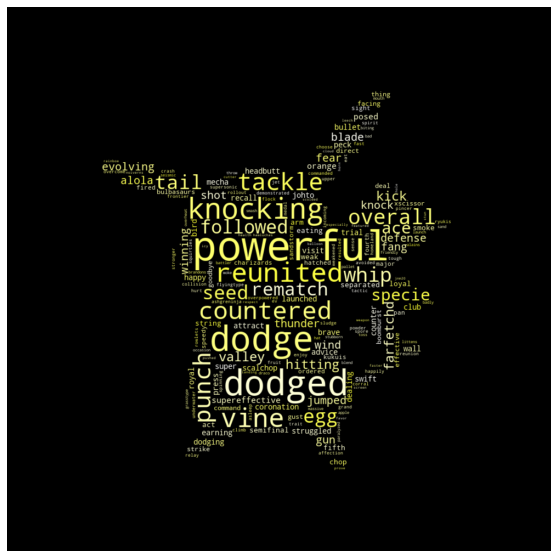

Other Pókemons


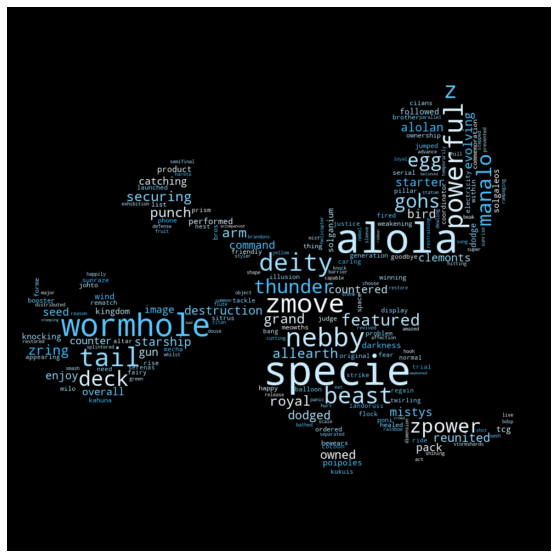

Gym Leaders


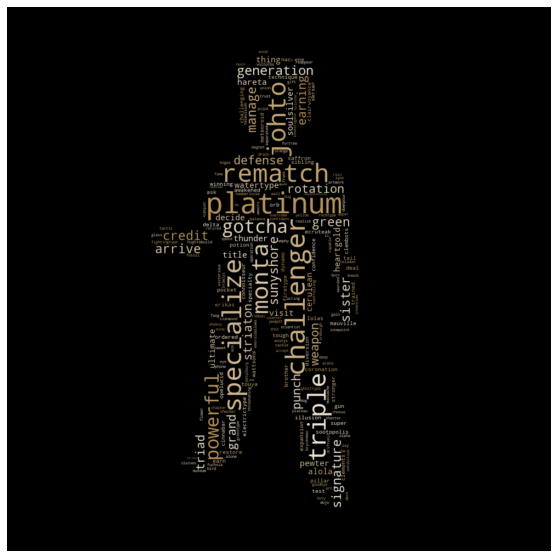

Elite Four + Champions


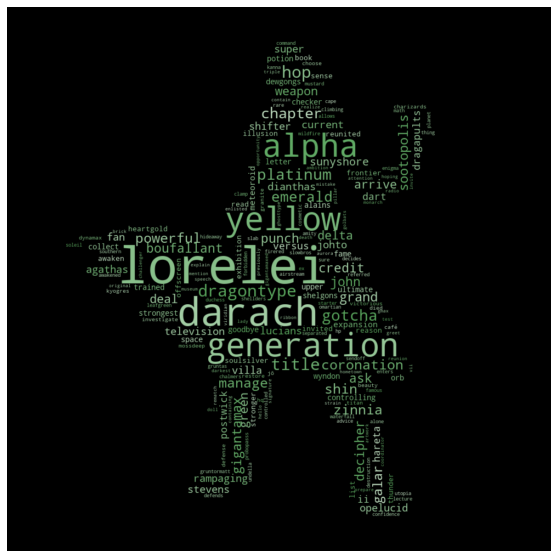

Rivals


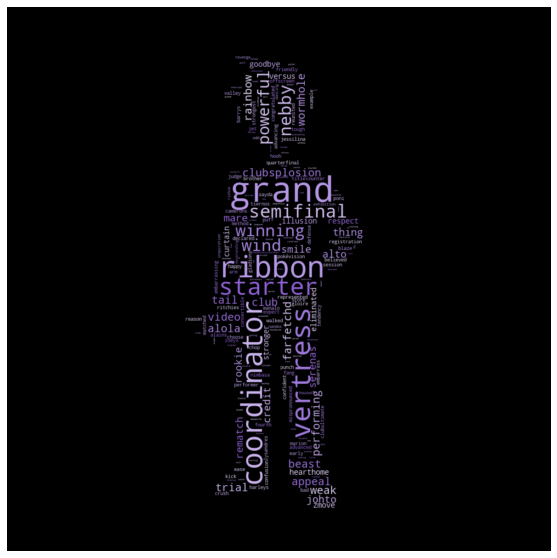

Professors


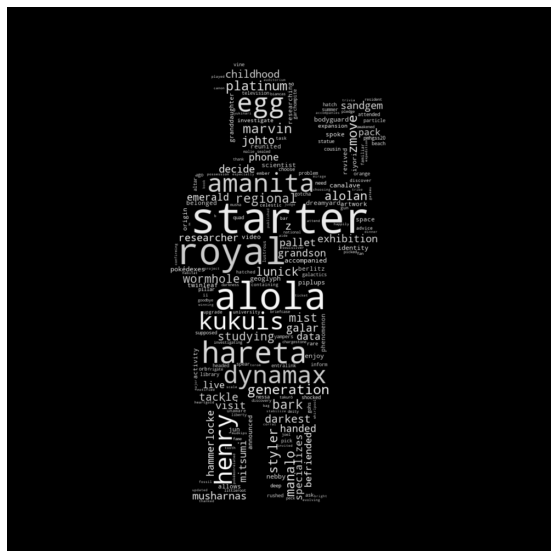

Team Rocket


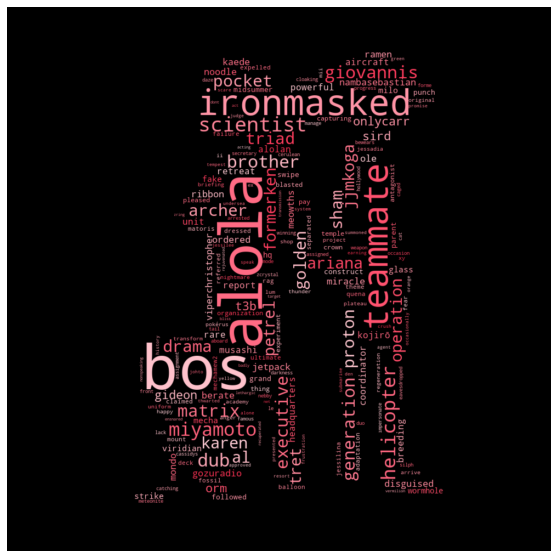

Villain team members


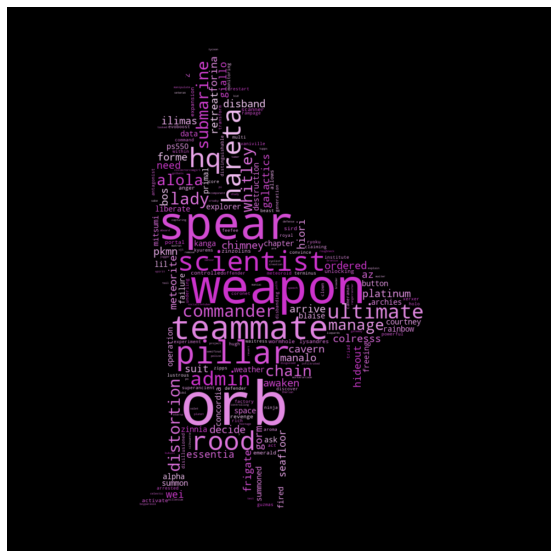

In [71]:
#make the wordclouds for the eight categories and print them
def make_wordclouds():
    for i, text in enumerate(complete_text):
        string = ""
        for key, value in tc_idf(text).items():
            string += ((key  + " ") * value)
        
        print(titles1[i])
        wordcloud = WordCloud(max_words=200, background_color="black", collocations=False, mask = masks[i], contour_width=3, contour_color='black').generate(string)
        plt.figure(figsize=[20,10])
        plt.imshow(wordcloud.recolor(color_func=color_functions[i], random_state=3), interpolation='bilinear')
        plt.axis("off")
        plt.show()
        

make_wordclouds()

### 3.9 Word-Clouds: Results
We created some beautiful word-clouds and if you have some knowledge of the pokemon universe, you can see that the words are representative for the categories.

# 3.10 Text Generation
Before we moved over to Part 4, we wanted to make something fun and interactive for our website. We came up with the idea to use NLP to generate an entirely new Pokémon based on the descriptions of already existing ones. First, we tried to use the built-in function <code>.generate()</code> from <code>nltk</code>. The resulting generated text didn’t make that much sense, so we decided on using a [Markov Chain](https://setosa.io/ev/markov-chains/) to generate our text. We implemented this generator from scratch, with inspiration from [this](https://healeycodes.com/generating-text-with-markov-chains) article. The way it works is that <code>build_model()</code> generates a chain of words that appear after each other. The state size determines how long these chains are. The larger the state size, the less random the resulting text becomes. Then <code>generate_text</code> generates the actual text. </br>
The text we wanted to generate was based on the description of the biology of all the Pokémon in the “national pokédex”. We scraped this data from bulbapedia, and stored them in a <code>.pickle</code> file.
We then generated a new random name, based on all other Pokémon names, and a new biology based on the biology descriptions of the Pokémon of the chosen type.

In [72]:
#build the markov chain model
def build_model(source, state_size):
    model = {}
    for i in range(state_size, len(source)):
        current_word = source[i]
        previous_words = ' '.join(source[i-state_size:i])
        if previous_words in model:
            model[previous_words].append(current_word)
        else:
            model[previous_words] = [current_word]
    return model

#generate the text bassed on the markov chains
def generate_text(model, state_size, min_length):
    def get_new_starter():
        return random.choice([s.split(' ') for s in model.keys() if s[0].isupper()])
    text = get_new_starter()
    i = state_size
    while True:
        key = ' '.join(text[i-state_size:i])
        if key not in model:
            text += get_new_starter()
            i += 1
            continue

        next_word = random.choice(model[key])
        text.append(next_word)
        i += 1
        if i > min_length and text[-1][-1] == '.':
            break
    return ' '.join(text)

The following cell is for scraping the pokemon pages, but we already ran it and saved in a .pickle file.

In [73]:
"""
url = "https://bulbapedia.bulbagarden.net/wiki/List_of_Pokémon_by_National_Pokédex_number"
pokedex = pd.read_csv("website/pokemonNetwork.csv")

page1 = requests.get(url)

soup = BeautifulSoup(page1.text, 'lxml')
tables1 = soup.find_all('table',{'align':'center'})

typeslinks = {'Bug':[], 'Dark':[], 'Dragon':[], 'Electric':[], 'Fairy':[], 'Fighting':[], 'Fire':[], 'Flying':[], 'Ghost':[], 'Grass':[], 'Ground':[], 'Ice':[], 'Normal':[], 'Poison':[], 'Psychic':[], 'Rock':[], 'Steel':[], 'Water':[]}
alltypes = list(typeslinks.keys())

for table1 in tables1:
    rows = table1.findAll("tr")
    for row in rows:
        links = row.findAll("a")
        for link in links:
            if link.text in list(pokedex['Pokemon Name']):
                url = link.get("href")
            if link.text in typeslinks:
                typeslinks[link.text].append(url)
                
for t in alltypes:
    typeslinks[t] = list(set(typeslinks[t]))

def get_pokemon_text(url):
    page2 = requests.get(f'https://bulbapedia.bulbagarden.net{url}')
    soup1 = BeautifulSoup(page2.text, 'lxml')
    headers = soup1.findAll("h2")
    for header in headers:
        if header.text in "Biology":
            return header.find_next_sibling('p').text
    return ""

def get_descriptions(typee):
    descriptions = ""
    for url in typeslinks[typee]:
        descriptions += get_pokemon_text(url)
    return descriptions

descriptions = {}
for t in alltypes:
    descriptions[t] = get_descriptions(t)
    print(f'{t} done.')

pickle.dump(descriptions, open("descriptions.p", "wb"))
"""

'\nurl = "https://bulbapedia.bulbagarden.net/wiki/List_of_Pokémon_by_National_Pokédex_number"\npokedex = pd.read_csv("website/pokemonNetwork.csv")\n\npage1 = requests.get(url)\n\nsoup = BeautifulSoup(page1.text, \'lxml\')\ntables1 = soup.find_all(\'table\',{\'align\':\'center\'})\n\ntypeslinks = {\'Bug\':[], \'Dark\':[], \'Dragon\':[], \'Electric\':[], \'Fairy\':[], \'Fighting\':[], \'Fire\':[], \'Flying\':[], \'Ghost\':[], \'Grass\':[], \'Ground\':[], \'Ice\':[], \'Normal\':[], \'Poison\':[], \'Psychic\':[], \'Rock\':[], \'Steel\':[], \'Water\':[]}\nalltypes = list(typeslinks.keys())\n\nfor table1 in tables1:\n    rows = table1.findAll("tr")\n    for row in rows:\n        links = row.findAll("a")\n        for link in links:\n            if link.text in list(pokedex[\'Pokemon Name\']):\n                url = link.get("href")\n            if link.text in typeslinks:\n                typeslinks[link.text].append(url)\n                \nfor t in alltypes:\n    typeslinks[t] = list(set(typ

In [75]:
descriptions = pickle.load( open( "data/descriptions.p", "rb" ) )
pokedex = pd.read_csv("data/pokemonNetwork.csv")

pkmn = pokedex['Pokemon Name'].tolist()
name_tokens = []
for name in pkmn:
    name_tokens.append(list(name))
nt = nltk.Text(sum(name_tokens, []))

def generate_pkmn_name():
    state_size1 = 2
    min_length1 = 100
    poe1 = build_model(nt, state_size1)
    text1 = generate_text(poe1, state_size1, min_length1)
    text2 = text1[:random.randint(10, 20)]
    return text2.replace(' ', '').lower().capitalize()

In [76]:
def update(typee):
    tokens = tk.tokenize(descriptions[typee])
    new_name = generate_pkmn_name()

    for name in pkmn:
        tokens = [new_name if x == name else x for x in tokens]
    tokens = ['' if x.lower() == 'farfetch' else x for x in tokens]
    tokens = ['' if x.lower() == 'nidoran' else x for x in tokens]
    full_text = nltk.Text(tokens)

    state_size = 2
    min_length = 100
    model = build_model(full_text, state_size)
    text = generate_text(model, state_size, min_length)

    text = text.replace(" ,", ",")
    text = text.replace(" .", ".")
    text = text.replace(" ' ", "'")
    text = text.replace(' - ', '-')
    text = text.replace(' ;', ';')
    return new_name, text

In [77]:
choose_your_type = "Fire"
new_name, text = update(choose_your_type)
print("------------ " + new_name + " ------------\n")
print(text)

------------ Suniume ------------

The black area has several red spots on its dark face. Its body is irregular in shape, and its face, and has been known to roast berries before eating them. Suniume is an orange pelt marked by jagged black stripes forming bands around them. Suniume stores and heats inhaled air in this sac and then burns it for energy. Before a battle, Suniume was the only known Pokémon that resembles a sentient chandelier. It has a bulbous snout and outwards from its upper jaw, and irises, have a dividing line across them.


# 4. Sentiment analysis

## 4.1 Character pages scrape

In the following part the BeautifulSoup and regex library is used to scrape each of the character's wiki pages and store the cleaned text of each paragraph in a dictionary, which can later be used for sentiment analysis. The dictionary is saved as csv and json file.

In [78]:
pokemon = pd.read_csv("data/fullData.csv")

In [79]:
pokemon

,Unnamed: 0,Name,Edges,Type,Relationship,Collection
0,0,Ash Ketchum,"[""Ash's Pikachu"", 'Delia Ketchum', 'Gary Oak',...",Main,Other,Original series
1,1,Delia Ketchum,"['Ash Ketchum', ""Ash's Pikachu"", 'Nurse Joy', ...",Recurring,Relative,Original series
2,2,Gary Oak,"['Ash Ketchum', 'Goh', ""Gary's cheerleaders"", ...",Recurring,Rival,Original series
3,3,Gary's cheerleaders,"['Gary Oak', 'Melissa', 'Ash Ketchum']",Recurring,Other,Original series
4,4,Ash's Pikachu,"['Ash Ketchum', ""Gary's Squirtle"", 'Officer Je...",Main,Pokémon,Original series
...,...,...,...,...,...,...
1881,1881,Caserin,0.0,One-timer,Pokémon,Side story
1882,1882,Corey Demario,0.0,One-timer,Other,Side story
1883,1883,Benny Demario,0.0,One-timer,Other,Side story
1884,1884,Shigeo,0.0,One-timer,Other,Side story


In [80]:
#Create a list of all character names and an empty dictionary to store the page content in
requestSession = requests.session()
characterListFull = list(pokemon['Name'])
pageContent = {}

#Function to generate a dictionary, which is storing each character as key and their page content as values
def generateContent(characterList):

    for i, character in enumerate(characterList):
        characterPage = requestSession.get(f"https://bulbapedia.bulbagarden.net/wiki/{character}")
        soup = BeautifulSoup(characterPage.text, 'lxml')
        
        # Extract the plain text content from paragraphs
        paras = []
        for paragraph in soup.find_all('p'):
            paras.append(str(paragraph.text))

        # Extract text from paragraph headers
        heads = []
        for head in soup.find_all('span', attrs={'mw-headline'}):
            heads.append(str(head.text))
    
        # Interleave paragraphs & headers
        text = [val for pair in zip(paras, heads) for val in pair]
        text = ' '.join(text)

        # Drop footnote superscripts in brackets
        text = re.sub(r"\[.*?\]+", '', text)
        
        #save each text with the character name as key in the dictionary
        pageContent[character]=text
        
    return pageContent

#generateContent(characterListFull)

In [81]:
# save content in json file
#import json

# create json object from dictionary
#json = json.dumps(pageContent)

# open file for writing, "w" 
#f = open("pageContent.json","w")

# write json object to file
#f.write(json)

# close file
#f.close()

In [83]:
pageContent = pd.read_json(r'data/pageContent.json', orient='index')

In [84]:
pageContent

,0
Ash Ketchum,Ash Ketchum (Japanese: サトシ Satoshi) is the mai...
Delia Ketchum,"Delia Ketchum (Japanese: ハナコ Hanako), also kno..."
Gary Oak,Gary Oak (Japanese: オーキド・シゲル Shigeru Okido) is...
Gary's cheerleaders,Gary's cheerleaders (Japanese: シゲル応援ギャル Shiger...
Ash's Pikachu,Ash's Pikachu (Japanese: サトシのピカチュウ Satoshi's P...
...,...
Crystal,Crystal (クリスタル) has several referrals.\n Game ...
Caserin,Caserin (Japanese: カスリン Caserine) and Luverin ...
Corey Demario,Corey Demario (Japanese: ツヨシ Tsuyoshi) is a ch...
Benny Demario,Benny Demario (Japanese: カンタ Kanta) is a chara...


## 4.2 Sentiment of each character

This part will analyse the sentiment of each of the character's pages, search for communities in the pokemon universe and compute their sentiment as well.

Note: The GCC is being used for this, as it does not change the outcome of the computation, both has been tried (the entire graph G and the GCC, in order to assure that no character is being left out. The sentiment and community rankings remain the same and performance is being optimized.

### 4.2.1 Import the character's page content

In [86]:
import json
with open('data/pageContent.json') as f:
    content = json.load(f)

In [87]:
#tokenize the text for usage of LabMT
def tokenize_text(text, remove_wikisyntax=False):
    '''
    removing punctuation, removing stopwords, lemmatize, set to lower case, and tokenize the sentence
    '''
    if remove_wikisyntax:
        text = re.sub(r'\{\{.*?\}\}', '', text)
        text = re.sub(r'\[\[.*?\]\]', '', text)
        text = re.sub(r'\<.*?\>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stopwords.words('english')]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

### 4.2.2 Sentiment analysis with LabMT

In [88]:
#first the LabMT wordlist is downloaded and stored
sentiment_url = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
sentiment_values = pd.read_csv(sentiment_url, skiprows=3, delimiter='\t')[['word', 'happiness_average']]

#defining a function to calculate the characters sentiment
def calculate_pages_sentiment(graph):
    for character in graph.nodes():
        try:
            page_content = repr(content[character])
            text = tokenize_text(page_content)
            sentiment = pd.DataFrame.from_dict(text)
            sentiment.columns = ['word']
        except FileNotFoundError:
            continue
        except KeyError:
            continue
        except ValueError:
            continue
        #text = tokenize_text(page_content)
        #sentiment = pd.DataFrame.from_dict(text)
        #sentiment.columns = ['word']
        sentiment['count'] = sentiment.groupby('word')['word'].transform('count')
        sentiment = sentiment.merge(sentiment_values, on=['word'])
        if sentiment.empty:
            continue
        sentiment['mean'] = (sentiment['happiness_average'] * sentiment['count']).sum() / \
                            sentiment['count'].sum()
        graph.nodes[character]['sentiment'] = sentiment['mean'].mean()
    pickle.dump(graph, io.open('{pokemon}_sent_graph.p', 'wb'))
    return graph

In [89]:
#calling the function to compute the sentiments and storing them in pokemon_graph
pokemon_graph = calculate_pages_sentiment(GCC)

In [90]:
#plotting the LabMT sentiment distribution
def plot_labmt_distribution(graph):
    sentiments = nx.get_node_attributes(graph, 'sentiment')
    title = "Sentiment distribution"
    caption = "Figure 6. The histogram is representing the distribution\nof all character's associated sentiments."
    values, bins = np.histogram([value for value in sentiments.values() if value is not np.nan],
                                10)
    plt.bar(bins[:-1], values, width=0.08)
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.grid()
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

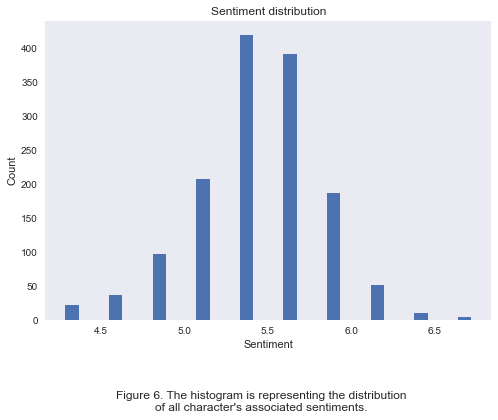

In [91]:
#applying the function to plot the sentiment distribution
plot_labmt_distribution(GCC)

The LabMT sentiment distribution looks normally distributed around an average sentiment of 5.5, which is considered as average happiness. The scores in LabMT range from 1.3 to 8.5 (least happy to most happy) with words like laughter at 8.5 and suicide at 1.3. There are no characters lying in the outer range of the sentiment scores and overall, there is a higher skewness of the distribution towards the happiest score of 8.5.

In [92]:
#storing the sentiments in a new dataframe
sentiments_df = pd.DataFrame.from_dict(dict(pokemon_graph.nodes(data=True)), orient='index')
sentiments_df = sentiments_df.dropna(subset=['sentiment'])

In [93]:
#printing out the happiest characters according to LabMT sentiment analysis
sentiments_df.sort_values(by='sentiment', ascending=False).head(10)

,sentiment
Nurse Joy,6.939859
Nurse Joy's Audino,6.877752
Nurse Joy's Comfey,6.782761
Nurse Joy's Wigglytuff,6.727746
Haircut brothers,6.694412
Elisa,6.547170
Nurse Joy's Blissey,6.529300
Mary's grandmother,6.525000
Kiawe's grandfather,6.464545
Santa Claus,6.462414


The happiest character according to LabMT is Nurse Joy, who are not one individual person but the nurses who are taking care of sick and injured Pokemon. They are described as very kind, honest and caring characters, who will confront trainers that are not properly taking care of their Pokemon. As the kind nurses of the Pokemon universe, who are saving and healing all Pokemon in need, they take a well deserved lead as the happiest character.

In [94]:
#printing out the saddest characters according to LabMT sentiment analysis
sentiments_df.sort_values(by='sentiment', ascending=True).head(10)

,sentiment
Jamero,4.328990
Drone Rotom,4.328990
Ash's Palpitoad,4.339820
Trevor's Charmander,4.394248
Shamus,4.410251
Spenser,4.450306
Georgia's Beartic,4.456036
Evelyn,4.468071
Tucker,4.471820
Ash's Pikachu,4.475925


The saddest character according to LabMT is Jamero. Jamero is a surveillance device and robotic training assistant, which is used to observe battles, overcome nearly all obstacles and make decisions in split seconds. According to LabMT these characteristics are classified with a negative sentiment. 

### 4.2.3 Sentiment analysis with Vader

In [95]:
#import SentimentIntensityAnalyzer class
analyzer = SentimentIntensityAnalyzer()

In [96]:
#using Vader to compute the sentiments
analyzer = SentimentIntensityAnalyzer()
def calculate_pages_sentiment_Vader(graph):
    for character in graph.nodes():
        try:
            page_content = repr(content[character])
        except FileNotFoundError:
            continue
        except KeyError:
            continue
        #text = tokenize_text(page_content)
        #text = [FreqDist(string) for string in text]
        #sentiment = pd.DataFrame.from_dict(text)
        analyzer = SentimentIntensityAnalyzer()
        sentiment_dict = analyzer.polarity_scores(page_content)
        sentiment_dict = sentiment_dict.get("compound")
        graph.nodes[character]['sentiment'] = sentiment_dict
    pickle.dump(graph, io.open('{pokemon}_sent_graph.p', 'wb'))
    return graph

In [97]:
#calculate the characters sentiment with Vader
pokemon_graph_Vader = calculate_pages_sentiment_Vader(GCC)

In [98]:
#plotting the LabMT sentiment distribution
def plot_Vader_distribution(graph):
    sentiments = nx.get_node_attributes(graph, 'sentiment')
    title = "Sentiment distribution"
    caption = "Figure 6. The histogram is representing the distribution\nof all character's associated sentiments."
    values, bins = np.histogram([value for value in sentiments.values() if value is not np.nan],
                                10)
    plt.bar(bins[:-1], values, width=0.08)
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.grid()
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

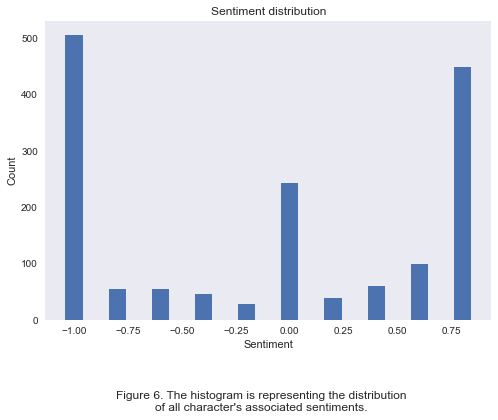

In [99]:
#applying the function to plot the sentiment distribution
plot_Vader_distribution(GCC)

Neutral sentiment lies between -0.05 and 0.05, above means positive and below is negative. There are around 250 characters with a neutral sentiment according to the Vader approach. The majority of around 500 characters have a very negative sentiment. A little bit less, around 460 characters, have a very positive sentiment.

In [100]:
#storing the sentiments in a new dataframe
sentiments_df_Vader = pd.DataFrame.from_dict(dict(pokemon_graph_Vader.nodes(data=True)), orient='index')
sentiments_df_Vader = sentiments_df_Vader.dropna(subset=['sentiment'])

In [101]:
#printing out the happiest characters according to Vader sentiment analysis
sentiments_df_Vader.sort_values(by='sentiment', ascending=False).head(10)

,sentiment
Nurse Joy,1.0000
Ash Ketchum,0.9999
Jessie,0.9995
Professor Oak,0.9995
Meowth,0.9993
Lillie,0.9992
Serena's Eevee,0.9991
Johanna,0.9991
Zoey,0.9990
Professor Rowan,0.9990


The happiest character according to Vader is Nurse Joy, which is the same result as the LabMT appraoch produces. In the contrary, Vader lists Ash Ketchum as the second happiest character though.

In [102]:
#printing out the saddest characters according to Vader sentiment analysis
sentiments_df_Vader.sort_values(by='sentiment', ascending=True).head(10)

,sentiment
Ash's Pikachu,-1.0000
Ash's Charmander,-0.9999
Ash's Treecko,-0.9998
Brock's Onix,-0.9997
Ash's Tepig,-0.9997
Archie,-0.9997
Ash's Bulbasaur,-0.9997
Ash's Oshawott,-0.9996
Maxie,-0.9996
Ash's Taillow,-0.9996


According to Vader, the saddest character is Pikachu. This can be reasoned with the nature of the character. Pikachu is the Pokemon of the main character Ash and has a lot of text on his page in which all their adventures and fights are described. Being a Pokemon, his storyline evolves a lot around battles and fighting, where negative sentiments apply more frequently than happy ones.

# 5. Communities

In the following the Louvain algorithm will be applied to identify communities in the network and analyse their sentiments.

Louvain’s algorithm was proposed by Vincent D. Blondel, Jean-Loup Guillaume, Renaud Lambiotte and Etienne Lefebvre in their paper from 2008:
https://arxiv.org/pdf/0803.0476.pdf

The algorithm was developed first by Etienne Lefebvre during his time at the Université catholique de Louvain in Belgium, which gave it its name.

The Louvain algorithm is divided in 2 phases: Modularity Optimization and Community Aggregation. In the first phase the algorithm orders all nodes randomly in the network. In the second phase it will remove and insert each node, one by one, in a different community until no significant increase in modularity is verified. These two steps are repeated until there are no more changes in the network and the modularity is at its maximum.

In order to use the Louvain algorithm for the communities, which is not working on a directed graph, the GCC is converted into a undirected graph.

In [103]:
GCC = GCC.to_undirected()

## 5.1 Plotting the communities

In the following the communities are computed and visualized with the ForceAtlas2 library.

In [104]:
#Using a color palet to select the colors for the communities in the function later on
color_palet = {}
color_palet['flashy green'] = "#53ff11"
color_palet['dark green'] = "#26ac00"
color_palet['flashy blue'] = "#00e1ff"
color_palet['flashy pink'] = "#ff01c1"
color_palet['flashy pink alt'] = "#dd2bd4"
color_palet['flashy purple'] = "#5900b3"
color_palet['flashy yellow'] = "#fdff01"
color_palet['black'] = "#000000"
color_palet['rm yellow'] = "#fafd7c"
color_palet['rm brown'] = "#82491e"
color_palet['rm navy blue'] = "#24325f"
color_palet['rm light blue'] = "#b7e4f9"
color_palet['rm dark blue'] = "#69c8ec"
color_palet['rm blue alt'] = "#a6eee6"
color_palet['rm red'] = "#fb6467"
color_palet['rm green'] = "#526e2d"
color_palet['rm pink'] = "#e762d7"
color_palet['rm orange'] = "#e89242"

In [105]:
#Define a path to save the plots
path_plots = os.getcwd() + "/Plots/"

In [106]:
#Setup forceatlas2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.35,
                        strongGravityMode=False,
                        gravity=7,

                        # Log
                        verbose=False)

In [107]:
#Function to plot the communities and color them accordingly
def plot_communities(communities, name):
    print('Drawing of the', name, "graph")

    #create the lists and dicts needed to store nodes, colors and labels
    node_list = dict()
    node_colors = []
    labels = []
    num_communities = len(communities)-1

    for i in range(num_communities):
        if name == 'louvain':
            this_community = [key for (key, val) in communities.items() if val == i]
        else:
            this_community = communities[i]
    
        node_list[i] = this_community
    
    #Color and label each community
        if 'Ash Ketchum' in this_community:
            node_colors.append(color_palet['flashy green'])
            labels.append("Ash Ketchum")
        elif "Ash's Pikachu" in this_community:
            node_colors.append(color_palet['flashy yellow'])
            labels.append("Ash's Pikachu")
        elif "Karl" in this_community:
            node_colors.append(color_palet['rm navy blue'])
            labels.append("Karl")
        elif "Hau" in this_community:
            node_colors.append(color_palet['rm light blue'])
            labels.append("Hau")
        elif 'Mitch Mitchum' in this_community:
            node_colors.append(color_palet['rm green'])
            labels.append('Mitch Mitchum')
        elif 'Officer Jenny' in this_community:
            node_colors.append(color_palet['flashy purple'])
            labels.append('Officer Jenny')
        elif 'Jessie' in this_community:
            node_colors.append(color_palet['rm brown'])
            labels.append('Jessie')
        elif "Dawn's Piplup" in this_community:
            node_colors.append(color_palet['flashy pink'])
            labels.append("Dawn's Piplup")
        elif 'Delia' in this_community:
            node_colors.append(color_palet['rm pink'])
            labels.append('Delia')
        elif 'Alain' in this_community:
            node_colors.append(color_palet['rm red'])
            labels.append('Alain')
        elif 'Ash Ketchum' not in this_community and "Ash's Pikachu" not in this_community and 'Professor Oak' not in this_community:
            #Giving a random color to each of the remaining communities
            color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
            node_colors.append(color)

            #Find node with highest degree within community
            highest_degree = sorted(GCC.degree, key=lambda x: x[1], reverse=True)[0]
            labels.append(highest_degree[0])
        else:
            node_colors.append(color_palet['orange'])
            labels.append('Other')
  
    positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=50)
    plt.figure(figsize=(16,8), dpi=64)
  
    for ii in list(set(node_list)):
        nx.draw_networkx_nodes(GCC, 
                          positions, 
                          nodelist=node_list.get(ii), 
                          node_size=len(node_list.get(ii))*0.15, 
                          node_color=node_colors[ii], 
                          label="C" + str(ii) + ' - ' + labels[ii])
    #Display name of most central node on graph
        if labels[ii] == "Ash and Ash's Pikachu":
            plt.text(positions['Ash Ketchum'][0], positions['Ash Ketchum'][1], 'C' + str(ii) + ' Ash', bbox=dict(facecolor='grey', alpha=0.33))
            plt.text(positions["Ash's Pikachu"][0], positions["Ash's Pikachu"][1], 'C' + str(ii) + " Ash's Pikachu", bbox=dict(facecolor='grey', alpha=0.33))
        else:
            plt.text(positions[labels[ii]][0], positions[labels[ii]][1], 'C' + str(ii), bbox=dict(facecolor='grey', alpha=0.33))
    
      
    nx.draw_networkx_edges(GCC, positions, width=.5, alpha=.25)
    plt.legend()
    plt.axis('off')
    # plt.savefig(path_plots + 'community_' + name + '.png', format='png', transparent=True, bbox_inches='tight')
    plt.show()
    plt.close()

Drawing of the louvain graph


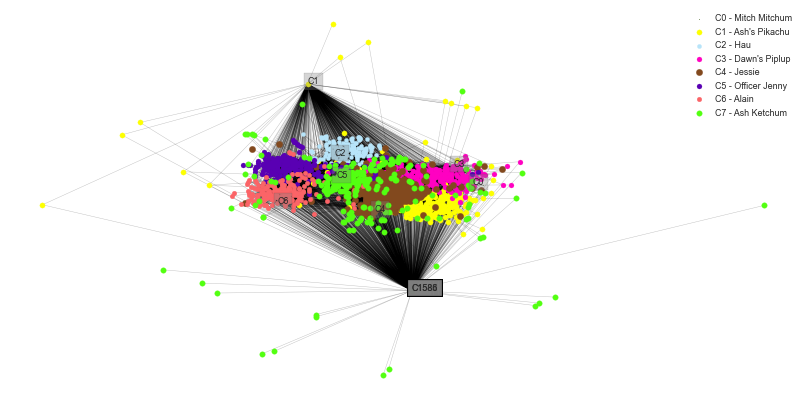

In [108]:
communities_louvain = community_louvain.best_partition(GCC, random_state=5)

plot_communities(communities_louvain, "louvain")

The 8 different communities are displayed above and each community is named after its node with the highest degree.

## 5.2 Community sentiments

In [109]:
#reverse the dict in order to store all characters in a list under the communities they belong to, which here will be the keys of the dict
partition = communities_louvain
from collections import defaultdict
def reverse_dict(partition: dict) -> dict:
    rd = defaultdict(list)
    for k, v in partition.items():
        rd[v].append(k)
    return rd

In [110]:
partition = reverse_dict(partition)

In [111]:
degreeRanking = sorted(GCC.degree, key=lambda x: x[1], reverse=True)

### 5.2.1 Get the names of the most connected nodes per community in order to distinguish the communities

In [112]:
#for every community number in the dictionary
def get_name(community_number):
    d = {}
    #looping through the dictionary with the communities
    for name in partition[community_number]:
        #looping through the list of names and degrees
        for elem in degreeRanking:
            if elem[0] == name:
                d[name] = elem[1]
    #extracting the top name with highest degree
    top = (sorted(d.items(), key = lambda x: x[1], reverse = True)[:2])
    #constructing the name
    name = top[0][0]
    return name

### 5.2.2 Computing the community sentiments with LabMT

In [113]:
#create a dictionary with each character and their community, so the communities can be added to the sentiment dataframe
commList = {}
for comm,char in partition.items():
    for character in char:
        commList[character] = comm

In [114]:
#extending the dataframe by adding the community of each character
sentiments_df["character"] = sentiments_df.index
sentiments_df["community"] = sentiments_df["character"].map(commList)
sentiments_df.reset_index(drop=True, inplace=True)

In [115]:
#grouping the communities and calculate the average sentiment
sentiments_df_avg = sentiments_df.groupby('community').mean()

In [116]:
#sorting the communities from high to low sentiment values
sentiments_df_avg.sort_values(by=['sentiment'], ascending=False)

,sentiment
community,
0,5.860905
7,5.634652
4,5.624965
2,5.605427
6,5.585097
1,5.562568
3,5.487019
5,5.485733


In [117]:
print("The happiest are the following communities:", get_name(0), ";", get_name(7), ";", get_name(4))

The happiest are the following communities: Mitch Mitchum ; Ash Ketchum ; Jessie


According to LabMT the community around the main character Mitch Mitchum is the happiest. The community around Mitch Mitchum is very small. His character's page shows that he is a nice guy, who is only trying to make his daughter happy by catching her most desired Pokemon. He even took a break from his job for this endeavour.

In [118]:
print("The saddest are the following communities:", get_name(5), ";", get_name(3), ";", get_name(1))

The saddest are the following communities: Officer Jenny ; Dawn's Piplup ; Ash's Pikachu


According to LabMT the community around Officer Jenny is the saddest one. Officer Jenny is not one individual person but rather all the police officers who use Pokemon. They are naturally dealing with villains and criminals, and their stories are mainly evolving around crimes and misfortunes, which reflects in their overall sentiment and those of the characters in their community.

### 5.2.3 Computing the community sentiments with Vader

In [119]:
#extending the dataframe by adding the respective community of each character
sentiments_df_Vader["character"] = sentiments_df_Vader.index
sentiments_df_Vader["community"] = sentiments_df_Vader["character"].map(commList)
sentiments_df_Vader.reset_index(drop=True, inplace=True)

In [120]:
#grouping the communities and calculate the average sentiment
sentiments_df_Vader_avg = sentiments_df_Vader.groupby('community').mean()

In [121]:
#sorting the communities from high to low sentiment values
sentiments_df_Vader_avg.sort_values(by=['sentiment'], ascending=False)

,sentiment
community,
0,0.515933
7,0.169830
1,0.048208
6,0.016545
4,-0.019818
2,-0.031890
3,-0.162240
5,-0.199233


In [122]:
print("The happiest are the following communities:", get_name(0), ";", get_name(7), ";", get_name(1))

The happiest are the following communities: Mitch Mitchum ; Ash Ketchum ; Ash's Pikachu


According to the Vader approach the community around Mitch Mitchum is the happiest, which is the same result as produced by the LabMT approach.

In [123]:
print("The saddest are the following communities:", get_name(5), ";", get_name(3), ";", get_name(2))

The saddest are the following communities: Officer Jenny ; Dawn's Piplup ; Delia Ketchum


According to Vader the community around Officer Jenny is the saddest one, which is the same result as produced by the LabMT approach.

## 5.3 Plotting the average sentiment per community for both approaches

In [124]:
#calculate the sentiment - standard deviation for each community
sentiments_df_std = sentiments_df.groupby('community').std()
sentiments_df_Vader_std = sentiments_df_Vader.groupby('community').std()

### 5.3.1 LabMT average sentiment per community

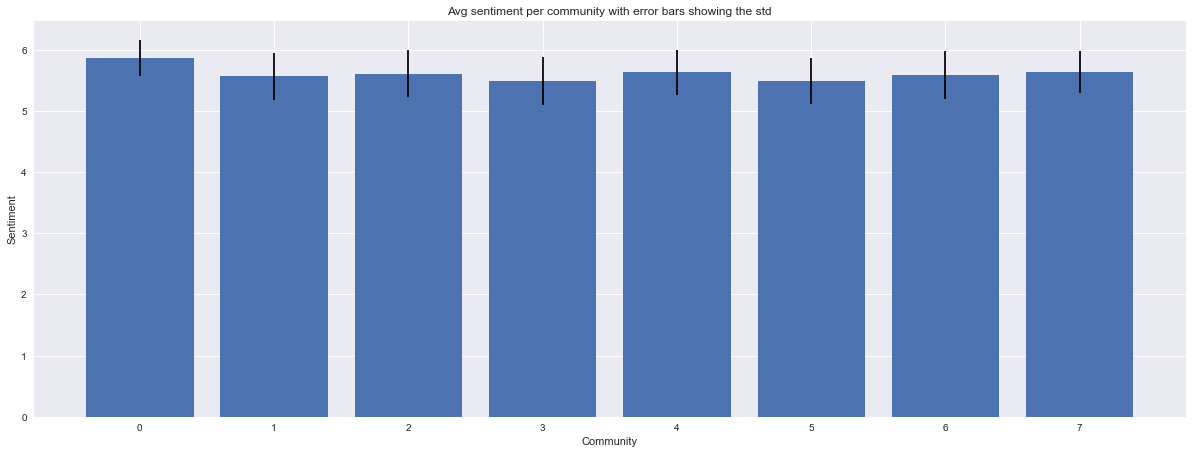

In [125]:
#bar plot with LabMT results
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
x = sentiments_df_avg.index
y = sentiments_df_avg["sentiment"]
ax.bar(x,y)               
er = errorbar(x,y,sentiments_df_std.sentiment, fmt="none", ecolor="black", capsize=5);
ax.set_xlabel("Community")
ax.set_ylabel("Sentiment")
ax.set_title("Avg sentiment per community with error bars showing the std")
ax.set_xticks(x)
plt.show()

The average sentiment for most communities is around 5.5, which fits the LabMT sentiment distribution shown above. Community 0, which is centred around Mitch Mitchum is the one with the highest average sentiment. The standard deviation lies within a range of approximately 1.0, which is reflected in the overall distribution ranging from a minimum 4.3 and maximum 6.9, with the majority of values lying within a 5.0 and 6.0 sentiment.

### 5.3.2 Vader average sentiment per community

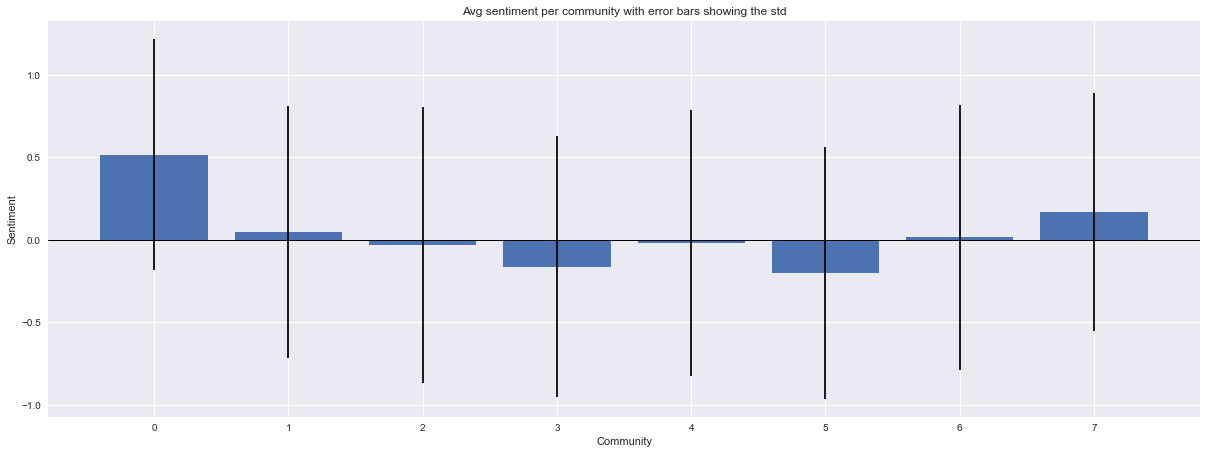

In [126]:
#bar plot with Vader results
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
x = sentiments_df_Vader_avg.index
y = sentiments_df_Vader_avg["sentiment"]
ax.bar(x,y)               
er = errorbar(x,y,sentiments_df_Vader_std.sentiment, fmt="none", ecolor="black", capsize=5);
ax.set_xlabel("Community")
ax.set_ylabel("Sentiment")
ax.set_title("Avg sentiment per community with error bars showing the std")
ax.set_xticks(x)
plt.axhline(y=0,linewidth=1, color='black')
plt.show()

Due to the standardization of the sentiment values, which is the compound value in the Vader method, the scale changes and neutral sentiment lies between -0.05 and 0.05, above means positive and below is negative. 

The average sentiment for communities 0 and 2 is positive, with Mitch Mitchum's community being by far the happiest. For communities 1, 3, 6 and 7 the average sentiment is neutral. And for the communities 4 and 5 a negative sentiment is computed. 

The range is high, and the sentiment varies from character to character, which leads to high standard deviations and long error bars. With the LabMT approach most of sentiments are within the 5.0 and 6.0 range leading to narrower standard deviation and shorter error bars.

For both approaches, the high average sentiment of Mitch Mitchums community can be reasoned by its very small nature. The community consists of only a few characters with high sentiment values.

# 6. Discussion and contribution

### 6.1 Discussion
#### What went well?

Starting this project, we set out to analyze the Pokémon games, not the anime - which resulted in a **much** smaller network. When recieving the feedback from the teachers, we were reminded by this and that we ideally should choose something larger for our final project. Not wanting to throw the idea of working with Pokémon out of the window, we analyzed the different wikis, and found that Bulbapedia had a large list of all characters in the anime. Upon scraping this data, we noticed that the network was indeed much larger having 9 times as many edges and double the amount of characters, as well as much more descriptive character pages.

Throughout the project, we've had a good collaboration policy, where we set out to not only use the tools learned in class, but also investigate how we can build upon these skills to learn something new. Having never done network analysis previously, we've picked up a great deal of tools in our belt that we feel confident to apply in new data exploring settings going forward. Additionally, we've learnt a great deal of information about the Pokémon network which we only had minimum knowledge about previously due to us being children when watching it. 

Additionally, we've sharpened our web tools, both for scraping data and presenting data in a website format.

### Improvements and further work

Given that this is a fixed time project, we'd love to keep exploring the network given x-amount of time/resources. What we'd like to explore is how the anime changes over time, given the different seasons, e.g. by analyzing segments over time (could the protagonist perhaps become more happy/sadder as he becomes a stronger trainer?). Another interesting thought we had, was to use the new Pokémon generator to actually create a visual representation of the Pokémon based on the description.





Overall, we had an even overall contribution in this project with everyone helping each other out - but each of our focus areas have been noted below:

**Kiriakos (s202669):**
Kiriakos focused mainly on part 4, analyzing the sentiments and part 5, building the communities. <br><br>
**Sebastian (s212266):**
Sebastians main focus was to work on part 3 of the assignment, NLP. This includes building the wordclouds, analyzing top words, creating this notebook and building the new Pokémon generator, as well as deploying this to the website using Streamlit.<br>

**Vetle (S203121):**
Vetle created the website, explanatory movies and worked on the data scraping and network building of the assignment (part 1 and 2) as well as assisting with the notebook and setting up the github.